<a href="https://colab.research.google.com/github/ShahidHasib586/MIR-Deep-learning/blob/main/Lab_Shahid_Ahamed_Hasib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning for sequential data - Lab

**Submission deadlines:**

* Get a minimum of 2 points by the end of the January 16th session.
* Get a minimum of 10 points by the end of the Januray 21st session (this includes the 2 previous points. That is, if you had 2 points in January 16th, then you only need to get extra 8 points in January 21st).
* Get the remaining 10+ points by January 30th at the latest.

If you miss a deadline, the amount of points expected by that deadline will be subtracted from your final score. E.g. if you missed the first deadline of 2 points and for your final submission you obtained 20 points, then your final grade will be 18.

*Points:* There are in total 26.5 points. **Aim to get a total of 20 points (i.e. 20 points = maximum grade)**. The passing grade is 10 points. If you get more than 20 points, the extra points will be counted towards the next lab. For each exercise below, its value in points is stated within parenthesis at the beginning of the exercise statement.

## Submission instructions:

We will have two submission modalities:

1. In person, during the sessions on January 21st and January 28th. Before each class, please fill in [this declaration form](https://docs.google.com/spreadsheets/d/11TpWUisSFcgdQTRkmWemm_VG1L9CXehFKo8NDkC6mnc/edit?gid=0#gid=0), in which you state which exercises you are ready to present. During class, I will randomly choose for each exercise a person from the ones that declared it as ready. If you are selected, you will present your solution. During your presentation I will likely ask questions. The questions could be slight modifications of the problem, or maybe asking you to walk me through some parts of it. There can be four outcomes:

    * **Your solution was correct and your presentation satisfactory** :D ! in which case **you get the full point**.
    * **Your solution was correct, but there were issues with your presentation** (mostly that you didn't show a proper understanding of your solution, or the topic at hand). In this case the earned points would be **between 50% and 75% of the original value of the exercise**.
    * **Your solution was incorrect (but complete)**. That's ok, you will be able to correct it during your presentation, and we will all try to help you :). **If you manage to correct it, you will get the full point. If not, you can get between 0% and 50% of the original value of the exercise**.
    * **You didn't have a solution or your solution was incomplete** (e.g. there was no output, the code was not finished, or you didn't have answers to the explicitly requested questions), which means you shouldn't have declared the exercise as ready. In such case, **you get a penalty of -2x the original value of the exercise** (e.g. if the exercise was worth 2 points, you get -4 points to your grade).

  I can ask more than one person to present per exercise if I don't find a solution/presentation convincing enough yet.
  
  If you are not called to present an exercise, and you declared it, you will get the full amount of points.


2. After the deadline of January 21st, you can submit the remaining 10+ points through Moodle (I'll enable a submission link). For every exercise you submit this way, detailed written explanations are required in the comments for every task. I will give more details later about the criteria for the written explanations.

  I tend to be more strict with written submissions, because I don't get to interact with you to assess your knowledge of the problem, and I can only use what you write. Therefore, I'd suggest you try to present in person as many exercises as you can.

I provide some starter code, however, you are not required to use it as long as you properly solve the tasks.

Make sure you know all the quetions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`).

**Reach out to me at santiago.cuervo@lis-lab.fr for any question or issue you might encounter.**

# Problem 1. RNNs on to the parity task

We will work on a toy problem: the parity task.

*Inputs:* a variable sized sequence of bits.

*Outputs:* a binary indicator that is `0` if the sequence contains an even number of ones and `1` otherwise.

Eg.

$x_1$: `0,0,0,1,0,1` , $y_1$: `0`

$x_2$: `0,0,0,1,0,1,1` , $y_2$: `1`

Note that this is equivalent to the RNN learning to apply a XOR function at each time step.

**Tasks**:

1. **(1 pt)** Implement the vanilla RNN in PyTorch. A vanilla RNN is described by the following recurrence:

    $H_t = \text{activation}(W_{xh}X_t + W_{hh} H_{t-1} + b_h)$

    Where $X_t$ are the inputs, $H_t$ are the states, $W_{xh}$ and $W_{hh}$ are weight matrices connecting the state to the inputs and the previous state, respectively, and $b_{h}$ is the bias term.

2. **(2 pt max.)** Use your RNN implementation to solve the parity task. For this:
    
    2.1 (0.5 pt) Implement the call to the forward pass of the RNN in order to compute the sequence of hidden states.
    
    2.2 (0.5 pt) Apply a simple MSE loss to train the network. Implement two training modes in which: 1) The loss is applied at each time-step and 2) The loss is applied only at the last timestep. There is a boolean flag in the code called `full_supervision` that controls this behavior.
    
    2.3 (1 pt) Play with the values of `full_supervision`, `max_grad_norm` and `seq_len` and analyze how it affects the training dynamics. Use suitable plots (e.g. for a binary variable like `full_supervision` a bar plot would suit) to illustrate the relation between these variables and the loss. Note that there is randomness due to the effect of random initialization and data sampling, so you shuld perform several experiments and report average results with deviations (e.g. standard deviations).



3. **(1 pt)** Implement the LSTM cell according to the equations from the slides and apply it to the parity task. Do you notice any change in the training dynamics?

3. **(0.5 pt)** In the setup without full supervision, try to train both the vanilla RNN and the LSTM in long sequences. Is there any advantage in using the LSTM?

In [ ]:
%matplotlib inline

In [ ]:
import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm

In [ ]:
# We'll be using very small networks, so things might go slower on a GPU. Change it to True if you want to try with GPU or things go slow
CUDA = False

In [ ]:
def np_to_tensor(np_var):
    t = torch.from_numpy(np_var)
    if CUDA:
        t = t.cuda()
    return t

## RNN implementation in PyTorch

Please note that PyTorch has RNN implementations (http://pytorch.org/docs/master/nn.html#recurrent-layers). For future projects please use the built-in mudules. They have more features, and are faster (they use the CuDNN library supplied by Nvidia).

**Attention**: in this code we will assume that the 0-th axis refers to time and that the 1-st axis refers to individual examples inside a minibatch. (This way in a C-major memory layout individual time steps occupy contiguous regions in memory)

## Explanation:

The following code implements a basic recurrent neural network (RNN) using PyTorch. The SimpleRNNCell class defines a single RNN cell that computes a new hidden state for each time step by combining the current input, the previous hidden state, and a bias term, followed by applying an activation function (default is Tanh). It includes trainable weights for input-to-hidden and hidden-to-hidden connections, as well as a bias, all initialized with a uniform distribution. The RNN class wraps around the SimpleRNNCell to process an entire sequence by iterating through its time steps. At each step, it updates the hidden state using the RNN cell and stores the outputs. The final output includes the last hidden state and the sequence of outputs, making this implementation suitable for tasks involving sequential data, such as language modeling.

In [ ]:
class SimpleRNNCell(nn.Module):  # Defines a custom RNN cell that processes one time step of data at a time.
    def __init__(self, in_dim, hidden_dim, activation=torch.nn.Tanh(), **kwargs):  # Initializes the RNN cell with input size, hidden size, and activation function.
        super(SimpleRNNCell, self).__init__(**kwargs)  # Calls the parent class's constructor to ensure proper initialization.
        self.activation = activation  # Specifies the activation function (default is Tanh).
        # Input to hidden
        self.Wxh = nn.Parameter(torch.Tensor(in_dim, hidden_dim))  # Creates a learnable weight matrix for input-to-hidden connections.
        # Hidden to hidden
        self.Whh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))  # Creates a learnable weight matrix for hidden-to-hidden connections.
        # Hidden bias
        self.bh = nn.Parameter(torch.Tensor(hidden_dim))  # Creates a learnable bias term for the hidden state.
        self.reset_parameters()  # Initializes the weights and biases.

    def reset_parameters(self):  # Resets the parameters to their initial values to ensure proper random initialization.
        stdv = 1. / math.sqrt(self.Whh.size(1))  # Computes the standard deviation for uniform initialization based on hidden dimension size.
        self.Wxh.data.uniform_(-stdv, stdv)  # Initializes the input-to-hidden weights uniformly within [-stdv, stdv].
        self.Whh.data.uniform_(-stdv, stdv)  # Initializes the hidden-to-hidden weights uniformly within [-stdv, stdv].
        self.bh.data.zero_()  # Initializes the bias values to zero.

    def forward(self, input, h):  # Defines the forward pass for one time step of the RNN cell.
        #
        # TODO TASK 1
        #
        # Compute the activation of the RNN cell (ie. the right hand side of the vanilla RNN equation)
        #
        pre_act = torch.matmul(input, self.Wxh) + torch.matmul(h, self.Whh) + self.bh  # Computes the pre-activation value by combining the input, previous hidden state, and bias.
        # This pre-activation (pre_act) serves as the input to the RNN's activation function, which determines the updated hidden state.
        return self.activation(pre_act)  # Applies the activation function to compute the new hidden state and returns it.


class RNN(nn.Module):  # Defines the RNN model that processes an entire sequence of data.
    def __init__(self, cell, **kwargs):  # Initializes the RNN model with the specified RNN cell.
        super(RNN, self).__init__(**kwargs)  # Calls the parent class's constructor to ensure proper initialization.
        self.cell = cell  # Stores the RNN cell to use for processing.

    def forward(self, input, hidden):  # Defines the forward pass for processing an entire input sequence.
        cell = self.cell  # Assigns the RNN cell for use within the function.
        output = []  # Initializes an empty list to store the outputs at each time step.
        #
        # TODO TASK 1
        #
        # Here we unroll in time and compute the recurrence
        #
        seq_len = input.size(0)  # Determines the length of the input sequence (number of time steps).
        for i in range(seq_len):  # Iterates through each time step of the input sequence.
            hidden = cell(input[i], hidden)  # Updates the hidden state using the current input and the previous hidden state.
            # Hack to handle LSTM
            output.append(hidden[0] if isinstance(hidden, tuple) else hidden)  # Handles the case where the cell might return a tuple (LSTM cell) and appends the appropriate output.

        output = torch.cat(output, 0).view(seq_len, *output[0].size())  # Concatenates the outputs from all time steps and reshapes them to match the sequence length.

        return hidden, output  # Returns the final hidden state and the sequence of outputs.


## The parity task

Here we solve the bit parity problem. Note that we will need at least two hidden neurons, because the network has to solve a XOR problem at each step.

## Explanation

This code generates binary sequences and their corresponding parity bit labels, where the parity is computed as the cumulative sum of the binary sequence modulo 2. The gen_parity_examples function creates a random binary input sequence (X) and calculates its parity (Y) over time for a specified sequence length and batch size. The output of the function is demonstrated by generating a single sequence of length 18 and printing both the input sequence and its parity in a transposed format for easy visualization.

In [ ]:
def gen_parity_examples(time_steps, batch_size):  # Function to generate parity bit examples for a given sequence length and batch size.
    X = (np.random.rand(time_steps, batch_size, 1) > 0.5).astype('float32')  # Creates a random binary sequence of shape (time_steps, batch_size, 1).
    Y = X.cumsum(0) % 2  # Computes the cumulative sum of X along the time axis, takes modulo 2 to generate parity bits.
    return X, Y  # Returns the generated input sequence (X) and corresponding parity labels (Y).

# Generate parity bit examples with a sequence length of 18 and a batch size of 1.
Xp, Yp = gen_parity_examples(18, 1)

# Print the transposed input sequence and parity labels for easier visualization.
print('X.T:', Xp.reshape(Xp.shape[:-1]).T, '\nY.T:', Yp.reshape(Yp.shape[:-1]).T)


X.T: [[0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.]] 
Y.T: [[0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1.]]


## Explanation
This code sets up and tests a simple RNN model. A 3D tensor input sequence with axes time x batch_size x num_features is processed by an RNN with a hidden dimension of 2. The initial hidden state is initialized to zeros. If GPU support is enabled (via CUDA), the RNN model is moved to the GPU for computation. The model is then run on the input sequence, producing the final hidden state and the hidden states for all time steps.

In [ ]:
# The input variable - a 3D tensor with axes:
# time x batch_size x num_features

hidden_dim = 2  # Defines the size of the hidden state in the RNN cell.
test_net = RNN(SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim))  # Creates an instance of the RNN using the SimpleRNNCell with input dimension 1 and hidden dimension 2.

if CUDA:  # Checks if CUDA (GPU support) is available.
    test_net.cuda()  # Moves the RNN model to the GPU for faster computation if CUDA is available.

h0 = np.zeros((1, hidden_dim), dtype='float32')  # Initializes the initial hidden state with zeros for a single sequence in the batch, matching the hidden dimension.

hn, out = test_net(np_to_tensor(Xp), np_to_tensor(h0))  # Feeds the input sequence (Xp) and initial hidden state (h0) to the RNN model.
# The network outputs a tuple of tensors: (last hidden state, hidden state at each time step).


## Explanation

The following code defines the ParityNet, a neural network for predicting parity bits from binary input sequences. The network uses either a simple RNN or an LSTM cell to process the input sequence and compute hidden states at each time step. The hidden states are concatenated with the input, and the resulting tensor is passed through a linear layer followed by a sigmoid activation to produce the final output. The network dynamically initializes its hidden states based on the input dimensions, making it flexible for various sequence lengths and batch sizes.

In [ ]:
class ParityNet(nn.Module):  # Defines a neural network for parity bit prediction.
    def __init__(self, hidden_dim, use_lstm=False, **kwargs):  # Initializes the network with hidden dimensions and an optional LSTM flag.
        super(ParityNet, self).__init__(**kwargs)  # Calls the parent class constructor to properly initialize the module.
        self.hidden_dim = hidden_dim  # Stores the hidden state dimension size.
        self.use_lstm = use_lstm  # Indicates whether to use an LSTM cell instead of a simple RNN cell.
        if use_lstm:  # Checks if LSTM is enabled.
            cell = LSTMCell(in_dim=1, hidden_dim=hidden_dim)  # Uses an LSTM cell if the flag is set to True.
        else:
            cell = SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim, activation=nn.Sigmoid())  # Uses a SimpleRNNCell with sigmoid activation otherwise.
        self.rnn = RNN(cell)  # Wraps the chosen cell in an RNN module to process sequences.
        self.linear = nn.Linear(in_features=1 + hidden_dim,  # Defines a linear layer for final output with input features (input + hidden states).
                                out_features=1)  # The output is a single feature per time step.

    def forward(self, inputs):  # Defines the forward pass of the network.
        if self.use_lstm:  # Checks if an LSTM cell is used.
            # Initializes LSTM hidden states (h and c) as zeros for each input in the batch.
            h0 = [torch.zeros((inputs.size(1), self.hidden_dim)).to(inputs.device) for _ in range(2)]
        else:
            # Initializes the hidden state as zeros for each input in the batch.
            h0 = torch.zeros((inputs.size(1), self.hidden_dim)).to(inputs.device)
        #
        # TODO TASK 2
        #
        # Compute the sequence of hidden states
        #
        _, H = self.rnn(inputs, h0)  # Processes the input sequence through the RNN and retrieves the hidden states at each time step.
        # Concatenate inputs and hidden states
        inputs_and_H = torch.cat((inputs, H), dim=2)  # Concatenates the input sequence with the hidden states along the feature dimension.
        return torch.sigmoid(self.linear(inputs_and_H))  # Applies the linear layer followed by a sigmoid activation to produce the final output.


Just to prove that the task is easily solvable, we will manually define the weights of our RNN to implement the XOR function:

## Explanation

The following code sets up and tests the ParityNet model for parity bit prediction. The weights and biases of the RNN cell and the final linear layer are manually configured to enforce specific behavior. The model processes a binary input sequence (Xp) and generates predictions, which are compared to the ground truth parity labels (Yp). The input, predicted outputs, and ground truth values are printed to verify the network's performance. The use of custom weights and biases makes this setup a controlled example for testing the network's functionality.

In [ ]:
parity_net = ParityNet(hidden_dim=2)  # Instantiates the ParityNet with a hidden state size of 2.

if CUDA:  # Checks if CUDA (GPU support) is available.
    parity_net.cuda()  # Moves the ParityNet model to the GPU for faster computation if CUDA is available.

#
# Design the net to solve parity
#
# Manually setting the weights and biases of the RNN cell for a specific behavior.
parity_net.rnn.cell.Wxh.data[...] = torch.FloatTensor([[2000, 1000]])  # Sets the input-to-hidden weight matrix.
parity_net.rnn.cell.Whh.data[...] = torch.FloatTensor([[ 1000,  1000],  # Sets the hidden-to-hidden weight matrix.
                                                       [-1000, -1000]])
parity_net.rnn.cell.bh.data[...] = torch.FloatTensor([-500, -1500])  # Sets the bias for the hidden state.

# Manually setting the weights and biases of the final linear layer for a specific behavior.
parity_net.linear.weight.data[...] = torch.FloatTensor([[ 0],  # Sets the weight matrix for the linear layer.
                                                        [ 1000],
                                                        [-1000]]).transpose(0, 1)
parity_net.linear.bias.data[...] = torch.FloatTensor([-500])  # Sets the bias for the linear layer.

# Generate predictions using the ParityNet model.
predictions = parity_net(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()  # Converts the input sequence to a tensor, feeds it into the network, and retrieves the predictions as a NumPy array.

# Print the input sequence, predicted outputs, and ground truth parity labels.
print('        X: ', Xp.squeeze())  # Prints the original binary input sequence.
print('predicted: ', np.round(predictions))  # Prints the predicted parity labels (rounded to nearest integer).
print('        Y: ', Yp.squeeze())  # Prints the ground truth parity labels.


        X:  [0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.]
predicted:  [0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1.]
        Y:  [0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1.]


Now we'll try to get to the solution by learning:

## Explanation

The Trainer class implements a training mechanism for a neural network using RMSProp optimization. It supports two modes of supervision: full supervision, where the loss is computed at each time step, and partial supervision, where the loss is computed only at the last step. The train_step method performs a single forward and backward pass, calculates the loss, applies gradient normalization to prevent exploding gradients, and updates the network parameters using RMSProp. The method returns the loss and gradient norm, allowing for monitoring during training.

In [ ]:

class Trainer(object):  # Defines a training class to train a neural network model.
    def __init__(self, network):  # Initializes the trainer with the specified network.
        # If full_supervision == True, supervise net outputs at all steps
        # If full_supervision == False, supervise net outputs at the last step only
        self.full_supervision = True  # Determines whether the training loss is calculated for every step (True) or only the last step (False).

        # When the total gradient is above this value, scale it down
        self.max_grad_norm = 1.0  # Maximum allowable gradient norm to prevent exploding gradients.

        self.network = network  # Stores the neural network to be trained.

        # RMSprop optimization stuff
        self.lrate = 1e-2  # Learning rate for the optimizer.
        self.RMSProp_dec_rate = 0.9  # Decay rate for RMSProp gradient averaging.
        self.RMSProp_epsilon = 1e-5  # Small value added to avoid division by zero during RMSProp updates.
        device = 'cuda' if CUDA else 'cpu'  # Determines whether to use GPU or CPU based on availability.
        self.gnorms = [torch.zeros(*p.size(), device=device)  # Initializes gradient norm tracking for RMSProp updates.
                       for p in self.network.parameters()]

    def train_step(self, X, Y):  # Defines a single training step for the network.
        X = np_to_tensor(X)  # Converts the input data to a PyTorch tensor.
        Y = np_to_tensor(Y)  # Converts the target data to a PyTorch tensor.
        net = self.network  # References the network for convenience.
        net.zero_grad()  # Resets gradients for the network parameters.

        # Predictions
        P = net(X)  # Performs a forward pass of the network to compute predictions.

        #
        # TODO TASK 2
        #
        # Implement the loss with and without full supervision.
        # With full supervision we compute the loss at each step.
        # Without, just at the last step
        #
        if self.full_supervision:  # If full supervision is enabled:
            loss = F.binary_cross_entropy(P, Y.expand_as(P))  # Compute the binary cross-entropy loss for all steps.
        else:  # If full supervision is disabled:
            loss = F.binary_cross_entropy(P[-1], Y[-1])  # Compute the binary cross-entropy loss for the last step only.
        loss.backward()  # Backpropagate to compute the gradients for all network parameters.

        tot_gnorm = torch.FloatTensor((0.0,))  # Initialize the total gradient norm.
        if CUDA:  # If CUDA is available:
            tot_gnorm = tot_gnorm.cuda()  # Move the gradient norm variable to GPU.

        # Apply gradient normalization to avoid exploding gradients and perform the training step.
        for p in net.parameters():  # Iterate through all network parameters:
            tot_gnorm += torch.sum(p.grad.data**2)  # Accumulate the squared gradient norm.
        tot_gnorm = torch.sqrt(tot_gnorm)  # Compute the total gradient norm.

        g_div = torch.max(torch.FloatTensor((self.max_grad_norm,))  # Compute the gradient normalization divisor.
                          .to(tot_gnorm.device), tot_gnorm)
        for i, p in enumerate(net.parameters()):  # Iterate through all parameters to update them:
            g = p.grad.data / g_div  # Scale the gradient by the divisor.
            self.gnorms[i] *= self.RMSProp_dec_rate  # Update the RMSProp gradient tracking.
            self.gnorms[i] += (1.0 - self.RMSProp_dec_rate) * g**2  # Update the moving average of squared gradients.
            p.data -= self.lrate * g / torch.sqrt(self.gnorms[i] + self.RMSProp_epsilon)  # Perform the parameter update using RMSProp.

        return dict(loss=loss.item(), grad_norm=tot_gnorm.item())  # Return the loss and gradient norm as a dictionary.

## Exploration of various problems with RNN training

In the following cell you can experiment with various ways of providing supervision to the network: which one is easier to train - when the net recieves feedback after each step or when it recieves feedback only at the end of training? Play with gradient clipping and the curriculum as well.

## Explanation

The train_and_eval_parity function trains a parity prediction model using the specified parity_trainer. It employs a curriculum learning approach, starting with shorter sequences and gradually increasing their length as training progresses. Loss and gradient norms are monitored and recorded, and training adapts dynamically based on performance. The function plots the training loss and gradient norms and evaluates the trained model on a test example, printing the input sequence, predicted parity, and ground truth. This setup ensures efficient training while providing insights into model performance.

In [ ]:
def train_and_eval_parity(parity_trainer, patience_max=3, max_iters=100000, learning_curriculum=True, stop_loss=1e-4):
    max_seq_len = 100  # Maximum sequence length for parity training.
    seq_len = max_seq_len  # Sets the initial sequence length.
    if learning_curriculum:  # If learning curriculum is enabled:
        seq_len = 10  # Start with a shorter sequence length to ease training.
    patience = patience_max  # Number of iterations to wait before increasing the sequence length.

    for i in range(max_iters):  # Main training loop for a maximum number of iterations.
        Xp, Yp = gen_parity_examples(np.random.randint(1, seq_len), 10)  # Generate random parity examples with varying sequence lengths and a batch size of 10.
        ret = parity_trainer.train_step(Xp, Yp)  # Perform a single training step with the generated examples.
        losses.append(dict(iter=i, **ret))  # Record the loss and gradient norm for this iteration.

        if ret['loss'] < stop_loss:  # Check if the loss is below the stopping threshold.
            patience -= 1  # Decrease patience if the loss condition is met.
            if patience == 0:  # If patience runs out:
                seq_len += 10  # Increase the sequence length.
                if seq_len > max_seq_len:  # Stop training if the maximum sequence length is reached.
                    break
                else:
                    patience = patience_max  # Reset patience for the new sequence length.
                print(i, "Increasing seq length to: ", seq_len)  # Log the sequence length increase.
        else:
            patience = patience_max  # Reset patience if the loss condition is not met.

        if i % 500 == 0:  # Print progress every 500 iterations.
            print(i, ret)

    # Convert the recorded losses to a DataFrame for analysis.
    losses_df = pd.DataFrame(losses)
    # Plot the training loss and gradient norm over iterations.
    plt.semilogy(losses_df['iter'], losses_df['loss'], label='loss')  # Plot the loss on a logarithmic scale.
    plt.semilogy(losses_df['iter'], losses_df['grad_norm'], label='grad norm', alpha=0.5)  # Plot the gradient norm with transparency.
    plt.legend(loc='lower left')  # Add a legend to the plot.
    plt.title('Training loss')  # Add a title to the plot.
    plt.xlabel('iteration')  # Label the x-axis as "iteration."

    # Evaluate the model on a sequence of length 10 with a batch size of 1.
    Xp, Yp = gen_parity_examples(10, 1)
    model = parity_trainer.network.eval()  # Set the model to evaluation mode.
    predictions = model(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()  # Generate predictions and convert to NumPy.
    print('        X: ', Xp.squeeze())  # Print the input binary sequence.
    print('predicted: ', np.round(predictions))  # Print the predicted parity bits (rounded).
    print('   target: ', Yp.squeeze())  # Print the ground truth parity bits.

    return losses_df  # Return the losses as a DataFrame for further analysis.

## Explanation

The code bellow initializes and trains a ParityNet model with a hidden state dimension of 3 using the Trainer class. The model is trained with full supervision, meaning the loss is computed at every time step. To prevent exploding gradients, gradient clipping is enabled with a maximum norm of 1. The training process uses a curriculum learning strategy, starting with shorter sequences and progressively increasing their length. The train_and_eval_parity function manages the training process, records losses, and evaluates the model. The final training results, including losses and gradient norms, are stored in Tra_Loss_Full_Supervision.

0 {'loss': 0.7099993824958801, 'grad_norm': 0.21651318669319153}
500 {'loss': 0.33335140347480774, 'grad_norm': 0.17817805707454681}
1000 {'loss': 0.5805805325508118, 'grad_norm': 0.07724292576313019}
1500 {'loss': 0.5612204670906067, 'grad_norm': 0.050683505833148956}
2000 {'loss': 0.46876347064971924, 'grad_norm': 0.051655545830726624}
2500 {'loss': 0.32681983709335327, 'grad_norm': 0.0950939804315567}
3000 {'loss': 0.4660685956478119, 'grad_norm': 0.08917509764432907}
3500 {'loss': 0.2816409468650818, 'grad_norm': 0.16407500207424164}
4000 {'loss': 0.26352185010910034, 'grad_norm': 0.14320270717144012}
4500 {'loss': 0.3403513729572296, 'grad_norm': 0.0866301879286766}
5000 {'loss': 0.4776674807071686, 'grad_norm': 0.11034202575683594}
5500 {'loss': 0.43549805879592896, 'grad_norm': 0.11623885482549667}
6000 {'loss': 0.05974220857024193, 'grad_norm': 0.4662233591079712}
6500 {'loss': 0.0027332683093845844, 'grad_norm': 0.003026131773367524}
7000 {'loss': 0.003151100827381015, 'grad_n

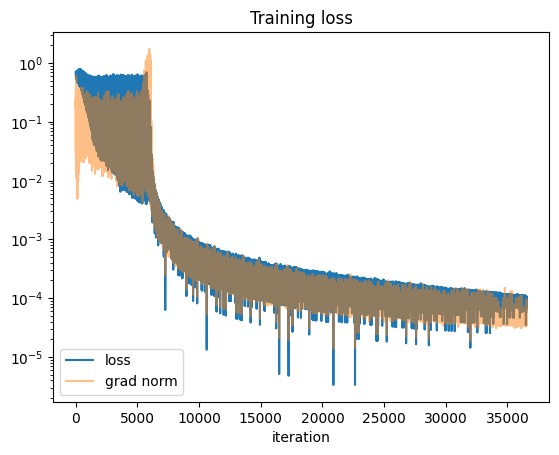

In [ ]:
parity_net = ParityNet(hidden_dim=3) # Create a ParityNet instance with a hidden state dimension of 3.
if CUDA: # Check if CUDA (GPU support) is available.
    parity_net.cuda() # Move the ParityNet model to the GPU if CUDA is enabled.
parity_trainer = Trainer(parity_net) # Initialize a Trainer instance for the ParityNet.
parity_trainer.lrate = 1e-2 # Set the learning rate for the Trainer.
losses = [] # Initialize an empty list to store training losses and gradient norms.
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True # Enable full supervision, where loss is computed at each step.
# Gradient clipping
parity_trainer.max_grad_norm = 1.0 # Set maximum gradient norm to avoid exploding gradients.
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = True # Enable curriculum learning to start with shorter sequences and increase gradually.
Tra_Loss_Full_Supervision = train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum) # Call the training and evaluation function, Pass the trainer instance to manage training steps, Use curriculum learning during training.

## Explanation

The graph illustrates the training progress of a neural network designed to solve the parity problem, which involves determining whether the count of ones in a sequence of binary digits is even or odd. The x-axis represents the number of training iterations, while the y-axis (logarithmic scale) tracks two key metrics: the loss and the gradient norm.

The loss curve reflects the model's prediction error, with values decreasing as the network learns to make more accurate predictions. The gradient norm measures the magnitude of changes in the network's parameters during training, offering insights into the learning dynamics. A high gradient norm early in training indicates significant parameter adjustments, while the stabilization later suggests convergence toward optimal values.

This training incorporates a curriculum learning strategy, beginning with shorter, simpler sequences and gradually introducing longer, more challenging ones as the network improves. This method facilitates gradual mastery, akin to progressing from basic to advanced problems. By the end, the network effectively predicts the parity of unseen sequences, confirming its ability to generalize the learned task. The consistent reduction in loss and stabilized gradient norms underscore the efficiency and success of the training process.

## Explanation

The train_and_eval_parity_mod function trains a parity prediction model using curriculum learning and adaptive patience. It gradually increases the sequence length during training based on the model's performance. The function tracks the training loss and gradient norms, which are stored in a DataFrame for further analysis.

The evaluate_and_visualize_model function visualizes the training loss and gradient norms over iterations and evaluates the trained model on a test sequence. It plots the loss and gradient norm curves and prints the input sequence, predicted parity, and true parity for comparison. This modular structure separates training and evaluation for better clarity and flexibility. Hyperparameter analysis.

In [ ]:
# Modified train and eval parity for compared visualization
def train_and_eval_parity_mod(parity_trainer, patience_max=3, max_iters=100000, learning_curriculum=True, stop_loss=1e-4, max_seq_len=100):
    seq_len = max_seq_len  # Define the maximum sequence length for training.

    if learning_curriculum:  # If curriculum learning is enabled:
        seq_len = 10  # Start with a smaller sequence length.

    patience = patience_max  # Initialize patience for training adjustments.

    losses = []  # Initialize a list to store training loss and gradient norms.

    for i in range(max_iters):  # Loop for a maximum number of iterations.
        Xp, Yp = gen_parity_examples(np.random.randint(1, seq_len), 10)  # Generate random parity examples with varying sequence lengths.
        ret = parity_trainer.train_step(Xp, Yp)  # Perform a single training step.

        losses.append(dict(iter=i, **ret))  # Record the loss and gradient norm.

        if ret['loss'] < stop_loss:  # If the loss is below the stopping threshold:
            patience -= 1  # Decrease patience.
            if patience == 0:  # If patience is exhausted:
                seq_len += 10  # Increase the sequence length.
                if seq_len > max_seq_len:  # If the sequence length exceeds the maximum:
                    break  # Stop training.
                else:
                    patience = patience_max  # Reset patience for the new sequence length.
        else:
            patience = patience_max  # Reset patience if the loss condition is not met.

    losses_df = pd.DataFrame(losses)  # Convert the recorded losses into a DataFrame.
    return losses_df  # Return the DataFrame containing the training losses and gradient norms.

# Evaluate and visualize model performance
def evaluate_and_visualize_model(losses_df, parity_trainer, gen_parity_examples, np_to_tensor):
    # Plot the training loss and gradient norm
    plt.semilogy(losses_df['iter'], losses_df['loss'], label='loss')  # Plot the loss on a logarithmic scale.
    plt.semilogy(losses_df['iter'], losses_df['grad_norm'], label='grad norm', alpha=0.5)  # Plot the gradient norm.
    plt.legend(loc='lower left')  # Add a legend to the plot.
    plt.title('Training Loss and Gradient Norm')  # Add a title to the plot.
    plt.xlabel('Iteration')  # Label the x-axis.
    plt.show()  # Display the plot.

    # Generate a set of examples to evaluate the model
    Xp, Yp = gen_parity_examples(10, 1)  # Generate examples with a sequence length of 10 and batch size of 1.

    # Set the model to evaluation mode
    model = parity_trainer.network.eval()  # Set the network to evaluation mode to disable training-specific behavior.

    # Get predictions from the model
    predictions = model(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()  # Make predictions and convert them to a NumPy array.

    # Print the input sequence, the model's predictions, and the target values
    print('        X: ', Xp.squeeze())  # Print the input binary sequence.
    print('predicted: ', np.round(predictions))  # Print the model's predictions (rounded to the nearest integer).
    print('   target: ', Yp.squeeze())  # Print the target parity values.

Training the loss with or without full supervision

In [ ]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting.

# Initialize a new ParityNet model with a hidden state dimension of 3.
parity_net = ParityNet(hidden_dim=3)
if CUDA:  # Check if CUDA (GPU support) is available.
    parity_net.cuda()  # Move the ParityNet model to the GPU if CUDA is enabled.

# Initialize a Trainer instance for the ParityNet.
parity_trainer_De = Trainer(parity_net)

parity_trainer.lrate = 1e-2  # Set the learning rate for the trainer.

losses = []  # Initialize an empty list to store training losses and gradient norms.

# Initialize and configure parity trainers
parity_trainer_De.full_supervision = False  # Disable full supervision, meaning the loss will only be computed at the last time step.

# Gradient clipping
parity_trainer_De.max_grad_norm = 1.0  # Set the maximum gradient norm to prevent exploding gradients during training.

# Train the model with curriculum learning and capture losses
print("Training Loss without Full Supervision")  # Indicate that the training without full supervision is starting.
Tra_Loss_Without_Full_Supervision = train_and_eval_parity_mod(parity_trainer_De, learning_curriculum=learning_curriculum); # Call the modified training function, Pass the parity trainer instance with full supervision disabled, Use curriculum learning during training

Training Loss without Full Supervision


## Explanation
In the first implimenatation the gradient clipping is set with a maximum norm of 1.0, whereas in the second implimenatation e impacts how the model handles large gradients during training, with a stricter limit in the second scenario to mitigate the risk of exploding gradients further. Additionally, the second implimenation I have explcitely mentioned that "Training Loss with varying Grad Max norm" to highlight the difference in gradient norms being tested.

In [ ]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True

# set grad norm to 0.5 for Gradient clipping
parity_trainer.max_grad_norm = 0.5

learning_curriculum = True
print("Training Loss with varying Grad Max normo")
Tra_Loss_max_grad_norm_0_5 = train_and_eval_parity_mod(parity_trainer, learning_curriculum=learning_curriculum)

Training Loss with varying Grad Max normo


Now try training Loss with 150 maximum sequence length (with changing sequence length)



In [ ]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True
# Gradient clipping
parity_trainer.max_grad_norm = 1.0
# This enables "curriculum learning" - we gradually train on longer and longer sequences
# Set the maximum sequence length for training examples.
max_seq_len = 150
learning_curriculum = True
print("Training Loss with 150 maximum sequence length")
train_loss_max_seq_len_150 = train_and_eval_parity_mod(parity_trainer, learning_curriculum=learning_curriculum,max_seq_len = 150)

Training Loss with 150 maximum sequence length


Training Loss with Full Supervision


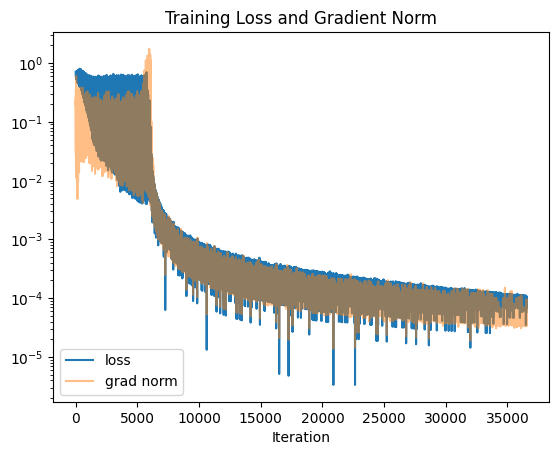

        X:  [1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
predicted:  [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
   target:  [1. 1. 1. 1. 0. 0. 0. 0. 1. 1.]
Training Loss without Full Supervision


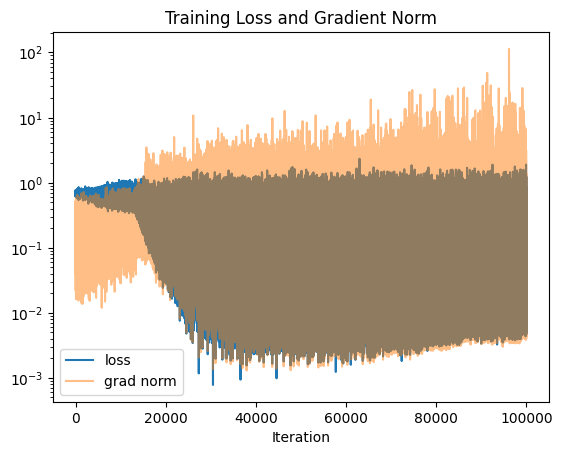

        X:  [0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
predicted:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
   target:  [0. 0. 0. 0. 1. 0. 1. 1. 0. 0.]
Training Loss 1 Grad Max normo


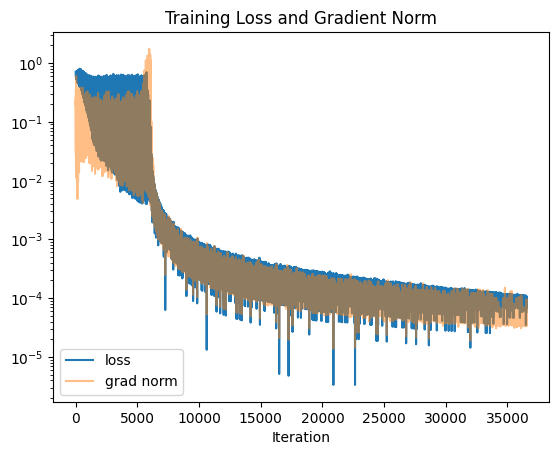

        X:  [1. 1. 1. 1. 1. 0. 1. 0. 0. 0.]
predicted:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   target:  [1. 0. 1. 0. 1. 1. 0. 0. 0. 0.]
Training Loss 0.5 Grad Max normo


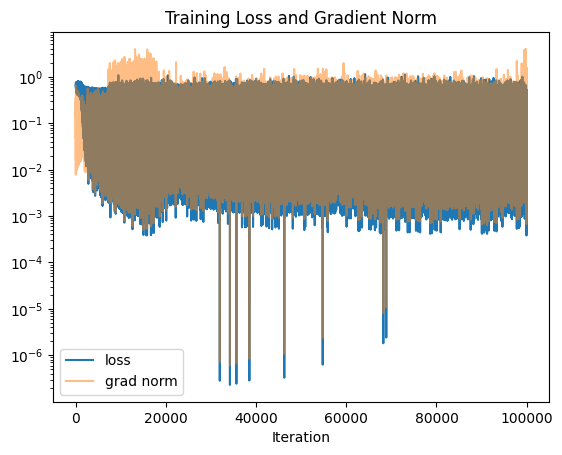

        X:  [0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
predicted:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
   target:  [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
Training Loss with 150 maximum sequence length


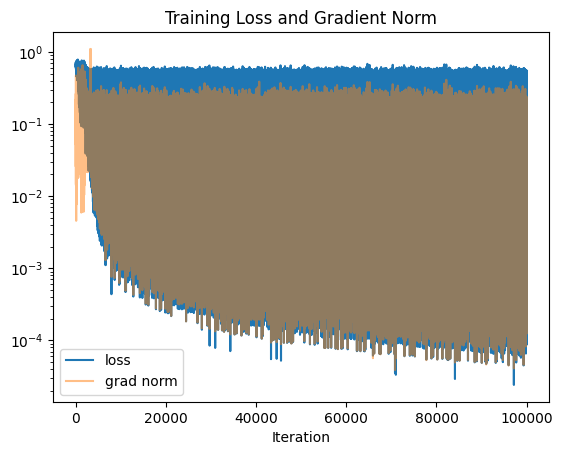

        X:  [0. 1. 1. 0. 1. 0. 1. 1. 1. 1.]
predicted:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
   target:  [0. 1. 0. 0. 1. 1. 0. 1. 0. 1.]


In [ ]:
print("Training Loss with Full Supervision")
evaluate_and_visualize_model(Tra_Loss_Full_Supervision, parity_trainer, gen_parity_examples, np_to_tensor)

print("Training Loss without Full Supervision")
evaluate_and_visualize_model(Tra_Loss_Without_Full_Supervision, parity_trainer, gen_parity_examples, np_to_tensor)

print("Training Loss 1 Grad Max normo")
evaluate_and_visualize_model(Tra_Loss_Full_Supervision, parity_trainer, gen_parity_examples, np_to_tensor)

print("Training Loss 0.5 Grad Max normo")
evaluate_and_visualize_model(Tra_Loss_max_grad_norm_0_5, parity_trainer, gen_parity_examples, np_to_tensor)

print("Training Loss with 150 maximum sequence length")
evaluate_and_visualize_model(train_loss_max_seq_len_150, parity_trainer, gen_parity_examples, np_to_tensor)


## LSTM

This LSTMCell class implements the core computations of an LSTM cell, which is a type of recurrent neural network (RNN) cell. The cell processes an input and the previous hidden and cell states to produce updated hidden and cell states. It uses four gates: the input gate, forget gate, cell gate, and output gate. These gates control the flow of information to maintain long-term dependencies in sequential data.


In [ ]:
class LSTMCell(nn.Module):  # Defines a single LSTM cell.
    def __init__(self, in_dim, hidden_dim, **kwargs):  # Initialize the LSTM cell with input and hidden dimensions
        super(LSTMCell, self).__init__(**kwargs)  # Call the parent class constructor to properly initialize the module
        self.in_to_gates = nn.Linear(in_dim, hidden_dim * 4, bias=True)  # Fully connected layer for input-to-gate computationn, combines input to all 4 gates
        self.hidden_to_gates = nn.Linear(hidden_dim, hidden_dim * 4, bias=False)  # Fully connected layer for hidden-to-gate computations

    def forward(self, input, hidden):  # Define the forward pass for the LSTM cell
        hx, cx = hidden  # Unpack the hidden state, `hx` for hidden state, `cx` for cell state
        gates = self.in_to_gates(input) + self.hidden_to_gates(hx)  # Compute the gate activations by summing input and hidden contributions

        # Split the combined gate activations into 4 components: input gate, forget gate, candidate cell state, and output gate
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        #
        # TODO TASK 3
        #
        # Implement the LSTM equations
        #
        ingate = torch.sigmoid(ingate)  # Input gate: decides how much of the input should influence the cell state
        forgetgate = torch.sigmoid(forgetgate)  # Forget gate: decides how much of the previous cell state to forget
        cellgate = torch.tanh(cellgate)  # Candidate cell state: represents potential updates to the cell state
        outgate = torch.sigmoid(outgate)  # Output gate: decides how much of the cell state to expose to the hidden state

        cy = forgetgate * cx + ingate * cellgate  # Update the cell state (`cy`) by combining forget gate, previous cell state, input gate, and candidate cell state
        hy = outgate * torch.tanh(cy)  # Compute the new hidden state (`hy`) using the output gate and the updated cell state

        return hy, cy  # Return the new hidden state and cell state

This code trains a ParityNet model with an LSTM cell using a Trainer class. Curriculum learning is applied to gradually increase sequence length during training, allowing the model to handle more complex sequences over time. Training losses and performance metrics are captured in LSTM_Loss for analysis and evaluation.

0 {'loss': 0.6538462042808533, 'grad_norm': 0.09883175790309906}
500 {'loss': 0.643269956111908, 'grad_norm': 0.07648149877786636}
1000 {'loss': 0.041214216500520706, 'grad_norm': 0.02202454023063183}
1500 {'loss': 0.0027964997570961714, 'grad_norm': 0.0018402300775051117}
2000 {'loss': 0.0011151502840220928, 'grad_norm': 0.0008641065796837211}
2500 {'loss': 0.000255087623372674, 'grad_norm': 0.0005008418229408562}
3000 {'loss': 0.000447029568022117, 'grad_norm': 0.0002732429711613804}
3500 {'loss': 0.00036644982174038887, 'grad_norm': 0.00023626913025509566}
4000 {'loss': 0.000353565119439736, 'grad_norm': 0.00022750299831386656}
4500 {'loss': 0.00030618038726970553, 'grad_norm': 0.00024299979850184172}
5000 {'loss': 0.0002973908558487892, 'grad_norm': 0.0002512322971597314}
5500 {'loss': 0.00022116233594715595, 'grad_norm': 0.00018587757949717343}
6000 {'loss': 0.00024292590387631208, 'grad_norm': 0.00019188250007573515}
6500 {'loss': 0.0001636906963540241, 'grad_norm': 0.00011006939

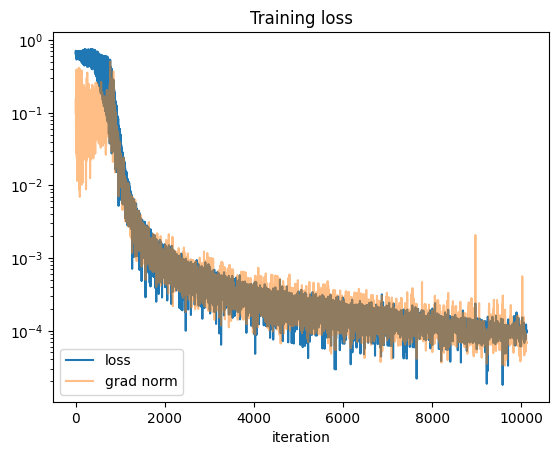

In [ ]:
parity_net = ParityNet(hidden_dim=3, use_lstm=True)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
losses = []
LSTM_Loss = train_and_eval_parity(parity_trainer, learning_curriculum=True)

## Explanation

The plot shows the training loss (blue) and gradient norm (orange) decreasing over iterations, indicating successful learning and convergence. The loss stabilizes at very low values, while the gradient norm reduces and smooths out, confirming no issues like exploding or vanishing gradients.

Loss Function Trend: The loss function (blue) drops sharply at the start, reflecting rapid learning and adaptation to the task. This indicates that the LSTM is effectively capturing sequence dependencies early in training.

Gradient Norm Fluctuations: The gradient norm (orange) spikes initially, as expected during the early phase when significant parameter updates occur. It then decreases and stabilizes, with smaller fluctuations, indicating that training is progressing smoothly and remains stable.

LSTM with long sequences:

In [ ]:
parity_net = ParityNet(hidden_dim=3, use_lstm=True)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
losses = []
LSTM_Loss_max_seq_len_200  = train_and_eval_parity_mod(parity_trainer, learning_curriculum=True, max_seq_len = 200)

## Explanation

Loss Function Dynamics: The loss function (blue) initially starts high and drops quickly, indicating that the LSTM is effectively learning patterns early in training. However, unlike smoother declines seen in earlier graphs, the loss shows an upward trend with noticeable variations as training progresses. This behavior may suggest that the LSTM is struggling to effectively model longer dependencies in the data.

Gradient Norm Fluctuations: The gradient norm (orange) exhibits significant variability, with frequent spikes throughout the training process. These fluctuations suggest difficulties in optimizing the loss function, likely compounded by the increased sequence length, which can lead to instability during training.

Impact of Sequence Length: The annotation indicates an increase in sequence length to 200, a challenging scenario for LSTMs due to issues like vanishing gradients. The heightened fluctuations in the graph after this point suggest that the network may be struggling to learn effectively from such long sequences with the current configuration.

RNN with long sequences:

In [ ]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = False
# Gradient clipping
parity_trainer.max_grad_norm = 1
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = True
RNN_Loss_max_seq_len_200 = train_and_eval_parity_mod(parity_trainer, learning_curriculum=learning_curriculum, max_seq_len = 200)

LSTM Loss max seq len 100


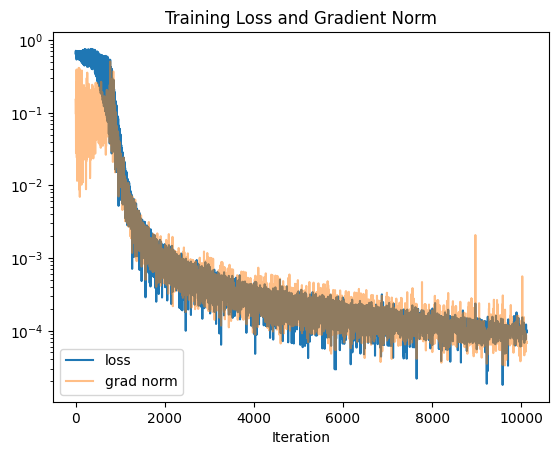

        X:  [1. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
predicted:  [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
   target:  [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
LSTM Loss max seq len 200


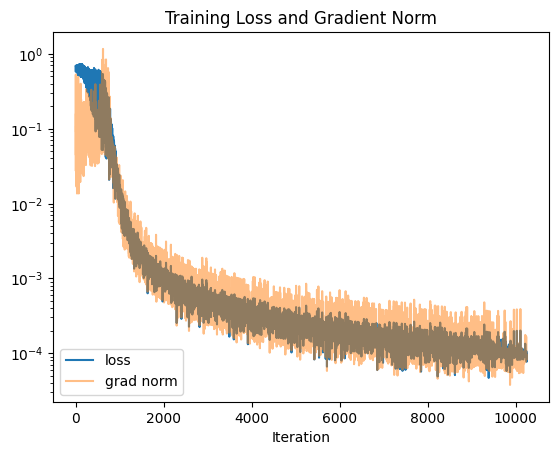

        X:  [1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
predicted:  [1. 1. 0. 1. 1. 1. 1. 0. 0. 0.]
   target:  [1. 1. 0. 1. 1. 1. 1. 0. 0. 0.]
RNN Loss max seq len 150


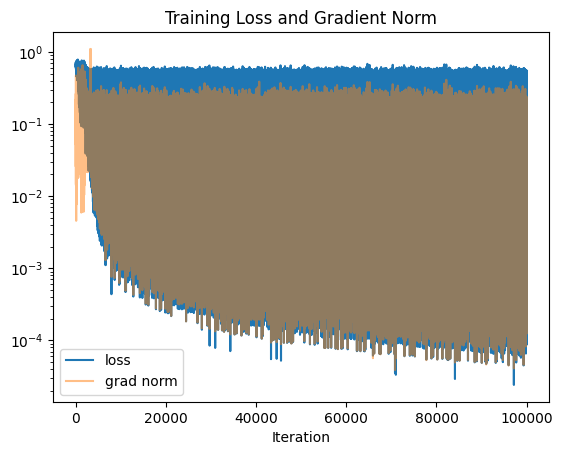

        X:  [0. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
predicted:  [0. 0. 0. 0. 1. 1. 0. 0. 1. 0.]
   target:  [0. 0. 0. 0. 1. 1. 0. 0. 1. 0.]
RNN Loss max seq len 200


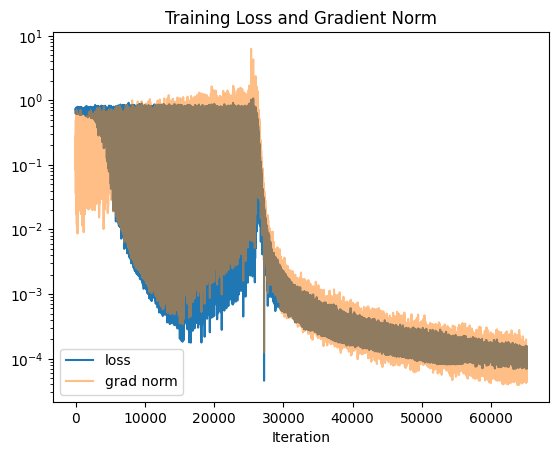

        X:  [1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
predicted:  [1. 1. 1. 1. 1. 0. 0. 0. 1. 1.]
   target:  [1. 1. 1. 1. 1. 0. 0. 0. 1. 1.]


In [ ]:
print('LSTM Loss max seq len 100')
evaluate_and_visualize_model(LSTM_Loss, parity_trainer, gen_parity_examples, np_to_tensor)
print('LSTM Loss max seq len 200')
evaluate_and_visualize_model(LSTM_Loss_max_seq_len_200, parity_trainer, gen_parity_examples, np_to_tensor)

print('RNN Loss max seq len 150')
evaluate_and_visualize_model(train_loss_max_seq_len_150, parity_trainer, gen_parity_examples, np_to_tensor)
print('RNN Loss max seq len 200')
evaluate_and_visualize_model(RNN_Loss_max_seq_len_200, parity_trainer, gen_parity_examples, np_to_tensor)


## Explanation

Training Loss with Full Supervision: In a fully supervised learning setup, where each input is paired with a correct output, the training loss typically decreases rapidly at the start and gradually plateaus as the model nears optimal performance. This scenario provides the model with complete labeled data, enabling it to effectively learn underlying patterns—a hallmark of ideal conditions for supervised tasks.

Training Loss without Full Supervision: In scenarios lacking full supervision, such as semi-supervised or unsupervised learning, the training loss may decline less predictably. Without explicit guidance from labeled data, the model must infer patterns or structures on its own, often leading to a slower, more irregular loss curve. In some cases, the loss may plateau if the model struggles to uncover meaningful structures in the data.

Training Loss by Changing Gradient Max Norm: Gradient clipping, controlled by the "Grad Max Norm" parameter, prevents exploding gradients by capping their maximum norm during backpropagation. Adjusting this parameter affects training stability—setting it too low can hinder learning, while a high threshold might fail to address exploding gradients. Finding the right balance is crucial for stable and effective training.

Training Loss by Changing Sequence Length: Sequence length significantly impacts learning in sequence-based tasks. Short sequences may lack sufficient context, while very long sequences can introduce challenges like vanishing gradients and high computational costs. Adjusting the sequence length helps balance these factors, optimizing the model's ability to process and learn from the data.

Training Loss with 150 Maximum Sequence Length: Limiting sequence length to a maximum of 150 tokens is often a practical choice to standardize inputs and manage computational resources. However, truncating sequences longer than 150 tokens risks discarding important information, which may affect the model's performance. While necessary for technical or resource-related reasons, this constraint could limit the model’s capacity to capture long-range dependencies in the data.

# Problem 2. GPT

Now we will implement the GPT architecture. GPT stands for _Generative Pre-trained Transformer_. GPT is a model trained to generate sequences, one token (character, word, or else) at a time, pretty similar to the RNN from slide 25 in our lecture. GPT is the architecture behind the immensely famous [ChatGPT](https://chat.openai.com/) and many other state-of-the-art AIs.

GPT training examples look like this (image taken from [GPT-3 Illustrated](https://jalammar.github.io/how-gpt3-works-visualizations-animations/)):

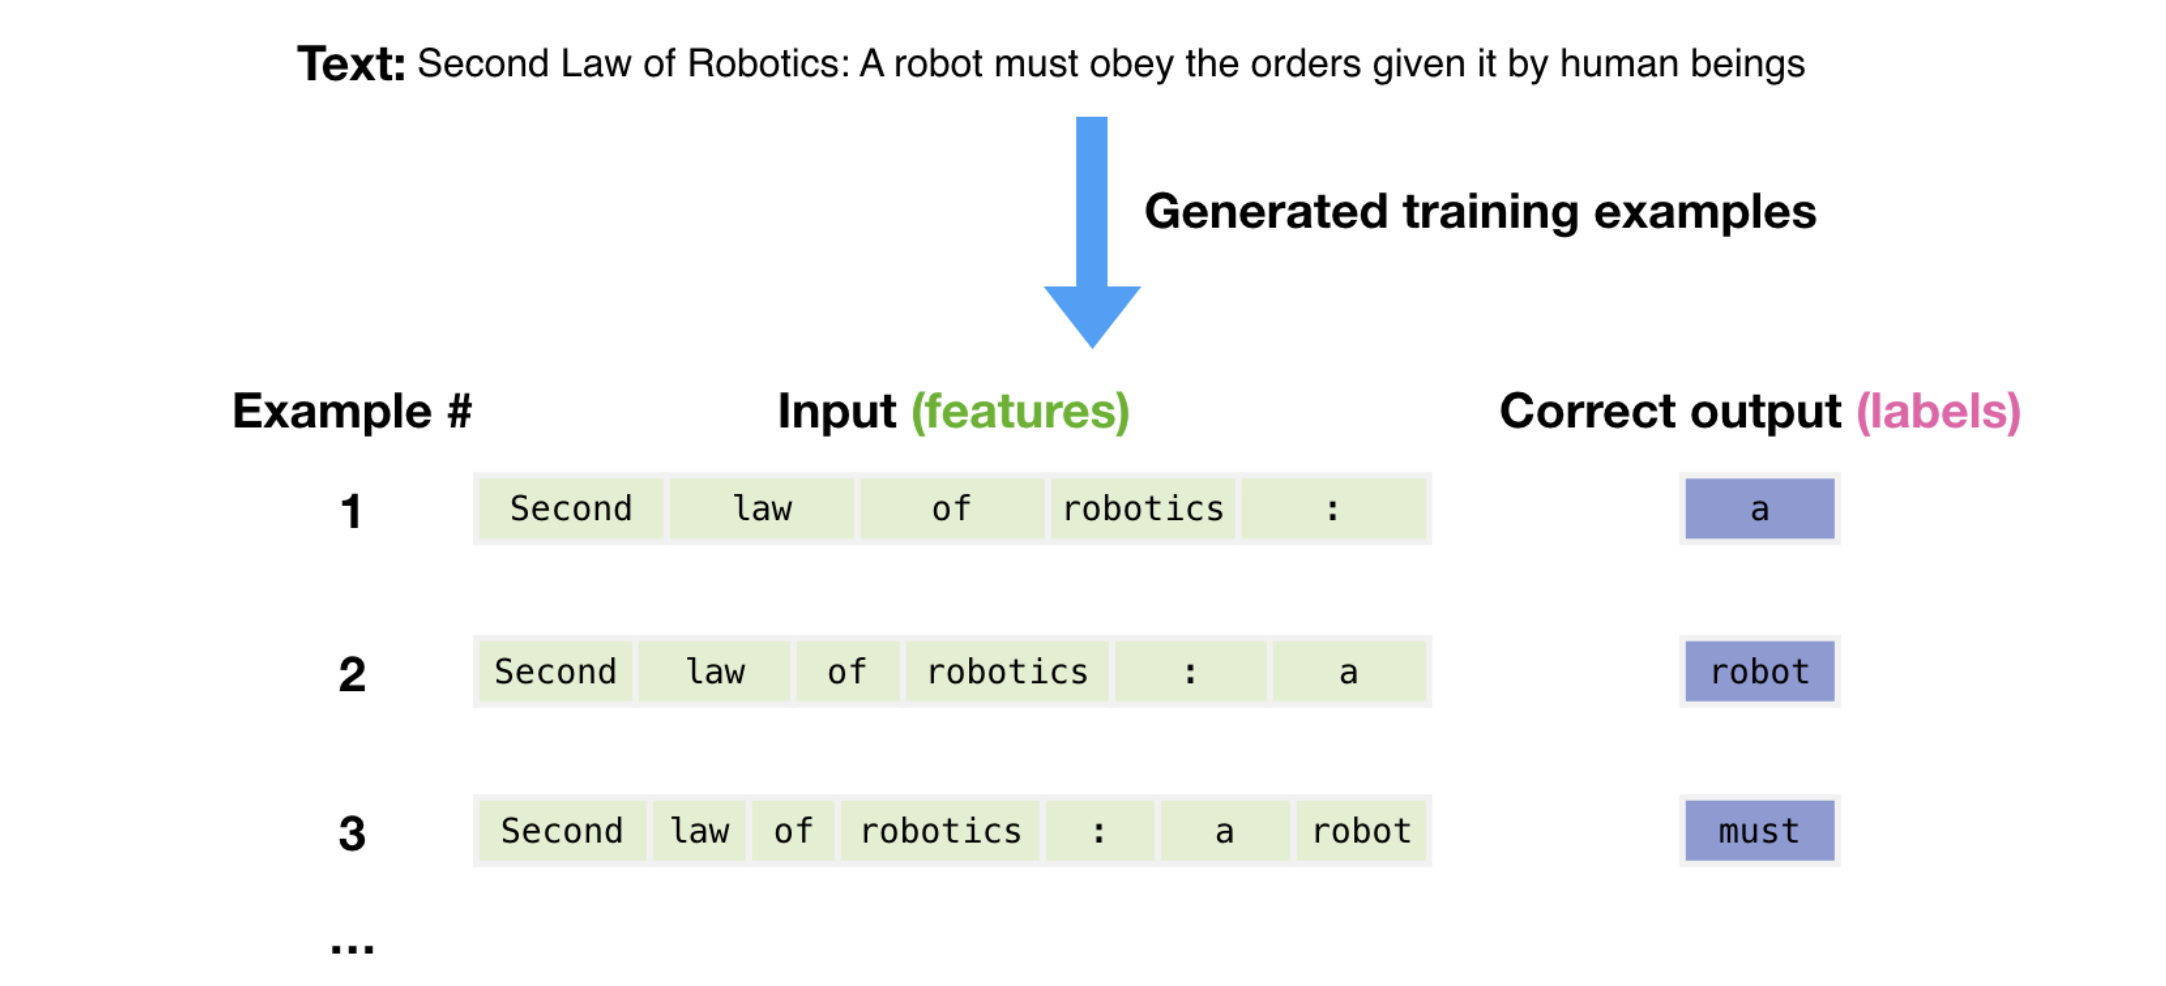![image.png](attachment:image.png)

So, in the example above, the input sequence would be `Second law of robotics: A robot must obey the orders given it by human`, and the target sequence would be `law of robotics: A robot must obey the orders given it by human beings`. In short words, GPT is a transformer trained to do next-token prediction. This is termed _auto-regressive modeling_.

Aside of the main transformer elements we saw in the lecture there is one extra things we need to take care of to implement GPT. First, a definition:

**Embedding**: a real valued vector of dimension $d$ (usually high-dimensional) representing something. E.g. neural nets can process numbers, but not words, so in order to get them to process text we assign an embedding to each word.

Now, thhe extra elements we need to implement:

**Positional encoding**:
    
Notice how none of the operations in the transformer cares about the position of the elements in the sequence. The only operation by which elements of the sequence interact with each other is self-attention, but self-attention is just a weighted average of the sequence elements. In a weighted average if you change the order of the elements the result is still the same.

Sequences however have an order. For instance, if we switch `robot` and `human` in the example above, yielding as input `Second law of robotics: A human must obey the orders given it by robot beings`, the meaning of the sentence has totally changed, but the output of the transformer would be the same as with the original!

To fix this we need to somehow inject information about the position. The way we do it is by adding to each embedding representing an input word another embedding to represent the position of such word. Consider $E$ a function that assigns embeddings to words, and $P$ a function that assigns embeddings to positions. Then, in our example, the input to the transformer would be:

$$
E(Second) + P(0), E(law) + P(1), E(of) + P(2), \dots, E(human) + P(14)
$$

The simplest way to implement positional encoding is using learned embeddings: we assume that we will process sequences of at most $T$ elements, and initialize randomly $T$ positional embeddings. During training, the model learns to modify our randomly initialize embeddings to better represent position. There are however many [methods for positional encodings](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/). This is actually a fairly active research area. Currently, the most popular (advanced) positional encoding method is [RoPE](https://blog.eleuther.ai/rotary-embeddings/).


So, in summary, in GPT:

1. We convert each input token in the sequence to an embedding and add to it a positional embedding.
2. We pass the encoded inputs through $N$ transformer blocks, which are just as the ones we described in class, except that we use causal self-attention instead of vanilla self-attention.
3. We use the output of the last transformer block as the input to a Softmax classifier that predicts the next-token in the sequence.

In the tasks below you will implement and use the GPT architecture.


**Tasks**:
1. **(3.5 pt)** Implement a transformer decoder block:

    1.1 **(2 pt)** Implement the forward pass of `MultiheadAttention`. You should implement the projection of the input embeddings to queries, keys and values (using `c_attn`), the computation of the causal attention matrix, and the output projection (using `c_proj`).
    
    _Note_: notice that we intend to do the query, key, and value projections in a single batched operation, therefore the `3 * n_embd` as output in `c_attn`. This is a more efficient implementation than doing separate linear projections for query, key, and value. However, you can use separate projection matrices if it is easier for you.
    
    _Note_: for the causal attention matrix you can use [masked_fill](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html#torch.Tensor.masked_fill_) in order to apply the mask.
    
    1.2. **(0.5 pt)** Implement the forward pass of the attention block in `Block`. Use the following transformer block as guide of the operations you should implement:
    
    <div>
        <img src="attachment:image-6.png" width="200"/>
    </div>     
    
    Where `Norm` corresponds to layer normalization, i.e. `ln_1` and `ln_2` in our implementation.
    
    1.3. **(1 pt)** Implement the forward pass of the transformer in `GPT`. In here you should implement the operations that apply the token embedding `wte` and position embedding `wpe` to the inputs, as well as the stack of transformer blocks `h`.

2. **(7.0 pt max)** Train a GPT to learn to generate Harry Potter text based on the first four books:

    2.1 **(0.5 pt)** As we mentioned, neural nets need to assign vectors to words/characters in order to process them. Normally for that we use the [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module, as in the `__init__` method from `GPT`. It assigns vectors to integer numbers, which themselves can correspond to discrete symbols, like our characters or words. For this exercise you have to encode our text as integer numbers (we call this process tokenization). We will start with the simplest tokenization: encode each character as an integer. You will need to create two dictionaries: `stoi` (string to integer) and `itos` (integer to string) that map text to integers and integers to text, respectively.
    
    2.2 **(0.5 pt)** Define the targets `y` in the `get_batch` function so that the model does next token prediction.
    
    2.3 **(4.5 pt max)** Implement the code to generate data in the function `generate` of `GPT`. Here you just need to feed back the predicted next tokens that the model outputs as input for the next time step (**0.5 pt**). You can also implement [top-k sampling](https://huggingface.co/blog/how-to-generate) for an extra **1 pt**, and/or [Key-Value caching](https://huggingface.co/blog/optimize-llm) to accelerate inference for extra **3 pt**.
    
    2.4 **(1.5 pt)** Improve the tokenization.
    
    Using character tokenization is a simple first approach, but is rarely used in practice because it results in too long sequences (remember that the computational complexity of transformers grows quadratically with the sequence length). As an alternative we could split the text by whitespaces (e.g. the sentence _"said Dumbledore, smiling"_ becomes `["said", "Dumbledore,", "smiling"]`), and then encode each unique word in the text as an integer. This is termed word tokenization, and although it solves our issue with length, it comes with its own problems. For instance, how do we deal with a word that was not in the training set? We could assign an special token for unknown words, but there is a better alternative: subword tokenization.
    
    Subword tokenization divides words into smaller, meaningful units, from which other words can be formed. Consider the word "_chatGPT_", and imagine you are using a word-level tokenizer that doesn't recognize the term because it's not present in its vocabulary. In such a case, the entire term will be treated as an out-of-vocabulary (OOV) word, and the model may struggle to understand or generate meaningful predictions for it. A subword tokenizer, instead of treating the entire term as a single token, it would would break it down into smaller, more meaningful subword units. For instance, it might tokenize "_chatGPT_" into `chat` and `GPT`. This would enable the model to leverage its already acquired knowledge of `chat` and `GPT` to infer that likely "_chatGPT_" is a `GPT` with which you can `chat`.
    
    Implement subword tokenization. You can use [SentencePiece](https://github.com/google/sentencepiece) or any other subword tokenizer of your chosing. Repeat training. Do you see any improvement?.

3. **(2.5 pt máx)** Evaluate the English skills of your Harry Potter GPT.
    
    If you have successfully trained your GPT, you should have now a neural network that generates (vaguely) Harry Potter related text. How good of an English it learned from it? In this task we will assess it by calculating how well our model can tell apart proper and wrong English. We will test it in two problems:
    
    * Spelling test: we will present our model with pairs of `[word, non-word]`, e.g. `[observation, odservation]`. We will check on average how often our model assigns higher probablity to the properlly spelled word.
    * Grammar test: we will present our model with pairs of `[sentence, non-sentence]`, e.g. `[Hermione is listening to herself, Hermione is listening to itself]`. We will check on average how often our model assigns higher probablity to the properlly spelled sentence.
    
    In this exercise your task is to implement the function that will calculate the score of the model (**2 pt**). Remember from the lecture that we define the probability of a sentence of length $T$ composed of tokens $x_1, x_2, \dots, x_T$ as:
    
    $$
    p(x_1, x_2, \dots, x_T) = p(x_1)p(x_2 | x_1)p(x_3 | x_1, x_2) \dots p(x_T | x_1, x_2, \dots, x_{T-1})
    $$
    
   , and that our model's inputs and outputs look like this:
   
   <div>
        <img src="attachment:image.png" width="500"/>
    </div>
    
    _Hint: think of the equation for the cross entropy loss with which our model is trained, it should give you an easy answer_.
    
    For extra **0.5 pt**, and if you did task 2.4, check if a model trained on subwords does better on the grammar test.

First, let's download the data we will need:

In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

![ -e hp1.txt ] || gdown 'https://drive.google.com/uc?id=1_3wY2jvzTZ6A933qez9CdcqTlr4uBrRC' -O hp1.txt
![ -e hp2.txt ] || gdown 'https://drive.google.com/uc?id=14fVcy8Ps72SyKV8hiROe0UQnIkdj38ji' -O hp2.txt
![ -e hp3.txt ] || gdown 'https://drive.google.com/uc?id=1nT8LDwx36T8HV9jCkwpofHruEfDaZ_c0' -O hp3.txt
![ -e hp4.txt ] || gdown 'https://drive.google.com/uc?id=19mhtuPs2OWer_ogDfyXpd3EXODwabt3c' -O hp4.txt
![ -e blimp.txt ] || gdown 'https://drive.google.com/uc?id=1D4MmosO1YH3osGjk25i7G-W6iyRf06_J' -O blimp.txt
![ -e wuggy.txt ] || gdown 'https://drive.google.com/uc?id=16N5kmaylACXIH4NkZjMvaDyvDv6Sa7xz' -O wuggy.txt

Downloading...
From: https://drive.google.com/uc?id=1_3wY2jvzTZ6A933qez9CdcqTlr4uBrRC
To: /content/hp1.txt
100% 440k/440k [00:00<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=14fVcy8Ps72SyKV8hiROe0UQnIkdj38ji
To: /content/hp2.txt
100% 492k/492k [00:00<00:00, 160MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nT8LDwx36T8HV9jCkwpofHruEfDaZ_c0
To: /content/hp3.txt
100% 612k/612k [00:00<00:00, 127MB/s]
Downloading...
From: https://drive.google.com/uc?id=19mhtuPs2OWer_ogDfyXpd3EXODwabt3c
To: /content/hp4.txt
100% 1.11M/1.11M [00:00<00:00, 164MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D4MmosO1YH3osGjk25i7G-W6iyRf06_J
To: /content/blimp.txt
100% 28.9k/28.9k [00:00<00:00, 68.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=16N5kmaylACXIH4NkZjMvaDyvDv6Sa7xz
To: /content/wuggy.txt
100% 736k/736k [00:00<00:00, 137MB/s]


In [ ]:

class MultiheadAttention(nn.Module):

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        assert n_embd % n_head == 0, "The embedding dimension must be divisible by the number of heads"
        self.n_head = n_head
        self.n_embd = n_embd
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=False)
        # output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).chunk(3, dim=-1)  # split into query, key, and value
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        #
        # TODO TASK 1.1
        #
        # Implement the forward pass of MultiheadAttention
        #
        att = (q @ k.transpose(-2, -1)) / (C // self.n_head) ** 0.5  # scaled dot-product attention
        masked_att = torch.tril(torch.ones(T, T, device=x.device))  # causal mask
        att = att.masked_fill(masked_att.unsqueeze(0).unsqueeze(0) == 0, float('-inf'))  # apply mask
        scores = F.softmax(att, dim=-1)  # softmax attention scores
        scores = self.attn_dropout(scores)
        # Compute attention output
        y = scores @ v  # weighted sum of values
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        y = self.resid_dropout(y)
        return y

class MLP(nn.Module):

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=False)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = MultiheadAttention(n_embd, n_head, block_size, dropout)
        self.ln_2 = nn.LayerNorm(n_embd)
        self.mlp = MLP(n_embd, dropout)

    def forward(self, x):
        #
        # TODO TASK 1.2
        #
        # Implement the forward pass of the attention block
        #
        x = x + self.attn(self.ln_1(x))  # attention and residual connection
        x = x + self.mlp(self.ln_2(x))  # feed-forward network and residual connection
        return x


class GPT(nn.Module):

    def __init__(self, n_layer, n_embd, n_head, block_size, vocab_size, dropout):
        super().__init__()
        self.block_size = block_size
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(vocab_size, n_embd),
            wpe=nn.Embedding(block_size, n_embd),
            drop=nn.Dropout(dropout),
            h=nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)]),
            ln_f=nn.LayerNorm(n_embd),
        ))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        # init all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        #
        # TODO TASK 1.3
        #
        # Implement the forward pass of the transformer
        #
        tok_emb = self.transformer.wte(idx)  # token embeddings of shape (b, t, n_embd)
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)  # position indices
        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (1, t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :])  # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                #
                # TODO TASK 2.3
                #
                # Implement top k sampling
                #
                values, indices = torch.topk(logits, top_k, dim=-1)
                logits = logits.masked_fill(logits < values[:, [-1]], float('-inf'))
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

First we load our data containing the first four Harry Potter books:

In [ ]:
data = ""
for i in range(4):
    input_file_path = f"hp{i + 1}.txt"
    with open(input_file_path, 'r', encoding='latin-1') as f:
        book = f.read()
    data += book + "\n"
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 2,652,656


Here the first few lines of the text:

In [ ]:
print(data[:500])

Harry Potter and the Sorcerer's Stone


CHAPTER ONE

THE BOY WHO LIVED

Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say
that they were perfectly normal, thank you very much. They were the last
people you'd expect to be involved in anything strange or mysterious,
because they just didn't hold with such nonsense.

Mr. Dursley was the director of a firm called Grunnings, which made
drills. He was a big, beefy man with hardly any neck, although he did
have a very large mustache


We compute the vocabulary size, i.e. the number of unique tokens in our data. We are working at the character level, so we will count the number of unique characters:

In [ ]:
# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

all the unique characters: 	
 !"$%&'()*,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ\]^_`abcdefghijklmnopqrstuvwxyz}~ü
vocab size: 91


Here you will integer encode the data. Define the two `dict` `stoi` and `itos` as described in the task 2.1. Afterwards we will split our data into train (first 90% of tokens) and validation (last 10% of tokens) sets

In [ ]:
# TODO TASK 2.1
#
# create a mapping from characters to integers (stoi) and from integers to characters (itos)
#
stoi = {ch: i for i, ch in enumerate(chars)}  # map characters to integers
itos = {i: ch for i, ch in enumerate(chars)}  # map integers to characters

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = encode(train_data)
val_ids = encode(val_data)
train_data = np.array(train_ids, dtype=np.uint16)
val_data = np.array(val_ids, dtype=np.uint16)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

train has 2,387,390 tokens
val has 265,266 tokens


Here we define some variables regarding training and the model. You can play with them, however it all should work with these default values:

In [ ]:
CUDA = True
device = "cuda" if CUDA else "cpu"
# data
batch_size = 32
block_size = 256
# model
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2
# adamw optimizer
learning_rate = 1e-3 # max learning rate
max_iters = 10000 # total number of training iterations
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
warmup_iters = 1000 # how many steps to warm up for
lr_decay_iters = max_iters
min_lr = 1e-4
# logging
eval_interval = 100
eval_iters = 10
log_interval = 10
# generation
max_new_tokens = 100
temperature = 0.8
top_k = 10

We define the function that will sample training batches. Here you should define `y` so that the model is trained for next-token prediction:

In [ ]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    # TODO TASK 2.2
    #
    # Define the targets that would implement next-token prediction
    #
    y = torch.stack([torch.from_numpy((data[i+1:i+block_size+1]).astype(np.int64)) for i in ix])
    if device == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


This function implements a learning rate schedule with a [warm-up phase and a cosine learning rate decay](https://residentmario.github.io/pytorch-training-performance-guide/lr-sched-and-optim.html#cosine-annealed-warm-restart). This turns out to be necessary to train transformer models.

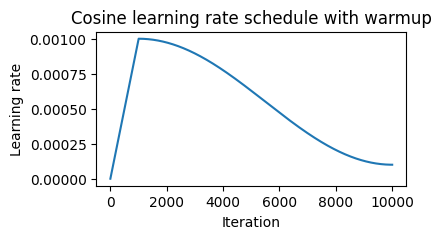

In [ ]:
# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

lr_seq = [get_lr(i) for i in range(max_iters)]
plt.figure(figsize=(4, 2))
plt.plot(lr_seq)
plt.title('Cosine learning rate schedule with warmup')
plt.xlabel('Iteration')
plt.ylabel('Learning rate')
plt.show()

For more details you can read [this post](https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/#Why_are_these_tricks_required).

Here we define our model, optimizer, and run our training:

In [ ]:
# We define the model
model = GPT(n_layer, n_embd, n_head, block_size, vocab_size, dropout)
model.to(device)
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
iter_num = 0 # number of iterations in the lifetime of this process
while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    # evaluate the loss on train/val sets
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        start = " "
        start_ids = encode(start)
        x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
        # run generation
        model.eval()
        try:
            with torch.no_grad():
                y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        except Exception as e:
            pass # If you haven't implemented the generate code
        model.train()
        print('-' * 100)
        print("Example generated:")
        print('-' * 100)
        print(decode(y[0].tolist()))
        print('-' * 100)
    logits, loss = model(X, Y)
    X, Y = get_batch('train')
    # clip the gradient
    if grad_clip != 0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0:
        lossf = loss.item() # loss as float. note: this is a CPU-GPU sync point
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms")
    iter_num += 1
    # termination conditions
    if iter_num > max_iters:
        break

step 0: train loss 4.5108, val loss 4.5109
----------------------------------------------------------------------------------------------------
Example generated:
----------------------------------------------------------------------------------------------------
 yE1,G'T&czd x D\^\KopDS?qsgo'Z`s
)(k0cx`]5$],GmyLlHC4f/2A3r9}xBR (nE	DsnMO2HMBd97c;m:sHrLc'\o\_
poP}
----------------------------------------------------------------------------------------------------
iter 0: loss 4.5108, time 3674.83ms
iter 10: loss 4.5100, time 194.07ms
iter 20: loss 4.5070, time 194.30ms
iter 30: loss 4.5004, time 198.04ms
iter 40: loss 4.4868, time 199.99ms
iter 50: loss 4.4685, time 201.16ms
iter 60: loss 4.4534, time 200.66ms
iter 70: loss 4.4362, time 199.29ms
iter 80: loss 4.4169, time 200.92ms
iter 90: loss 4.3894, time 201.28ms
step 100: train loss 4.3552, val loss 4.3496
----------------------------------------------------------------------------------------------------
Example generated:
--------

## Explanation

During the training of a GPT-like neural network model, the initial output typically consists of random and nonsensical text, as the model has not yet learned the structure and rules of the language. As training progresses, evidenced by decreasing loss values, the model adjusts its internal parameters to better predict language patterns. This process results in increasingly coherent and structured text generation, showcasing the model's growing ability to understand and replicate the complexities and nuances of human language. Over time, the outputs become more contextually relevant, fluent, and meaningful, reflecting the model's improved grasp of syntax, grammar, and semantics.

The application of top-K sampling plays a pivotal role in guiding the model's text generation, particularly during the early stages of training when the model's predictions are highly uncertain. By restricting the next-word predictions to the K most likely candidates, top-K sampling minimizes randomness and ensures more logical and contextually appropriate outputs. This technique not only enhances coherence but also mitigates issues such as the generation of nonsensical or irrelevant text. Combined with techniques like temperature scaling, which adjusts the probability distribution of predictions, top-K sampling enables the model to produce outputs that closely mimic human communication styles, even before it fully converges during training.

Additionally, top-p sampling (nucleus sampling) can complement or enhance top-K sampling by dynamically adjusting the range of potential outputs based on their cumulative probability. This hybrid approach allows the model to maintain diversity in its outputs while ensuring coherence, further improving text generation quality. Together, these sampling techniques are instrumental in shaping the model's behavior and aligning its generated content with natural human language patterns, especially in tasks like conversational AI, storytelling, and content generation.

Now we will assess the English knowledge of our trained model (Task 3). We load the pairs of words and sentences and print some examples:

In [ ]:
with open("wuggy.txt", 'r') as f:
    spelling_samples = [sample[:-1].split(',') for sample in f]
with open("blimp.txt", 'r') as f:
    grammar_test_samples = [sample[:-1].split(',') for sample in f]
print(spelling_samples[0])
print(grammar_test_samples[0])

['objectivity', 'osbrectifity']
["Harry hadn't attacked himself", "Harry hadn't attacked herself"]


In [ ]:
def get_sample_prob(X):
    #
    # TODO TASK 3
    #
    # Compute the probability of sequence X
    #
    logits, _ = model(X[:, :-1])
    log_probs = F.log_softmax(logits, dim=-1)

    targets = X[:, 1:]  # The target tokens are shifted by one position

    gathered_log_probs = torch.gather(log_probs, 2, targets.unsqueeze(1)).squeeze(2)
    # print(gathered_log_probs.shape)
    # Sum the log probabilities for the entire sequence
    sequence_log_prob = gathered_log_probs.sum()
    return torch.tensor(sequence_log_prob).cpu().detach()

spelling_scores = []
for sample in tqdm(spelling_samples):
    word, non_word = sample
    tokenized_word = torch.tensor(encode(word), dtype=torch.long).unsqueeze(0)  # Encode and batch
    prob_word = get_sample_prob(tokenized_word.to(device))
    tokenized_non_word = torch.tensor(encode(non_word), dtype=torch.long).unsqueeze(0)  # Encode and batch
    prob_non_word = get_sample_prob(tokenized_non_word.to(device))
    spelling_scores.append(1.0 * (prob_word > prob_non_word))  # Higher probability for the correct word
print("Spelling score: ", np.mean(spelling_scores))

grammar_scores = []
for sample in tqdm(grammar_test_samples):
    sentence, non_sentence = sample
    tokenized_sentence = torch.tensor(encode(sentence), dtype=torch.long).unsqueeze(0)  # Encode and batch
    prob_sentence = get_sample_prob(tokenized_sentence.to(device))
    tokenized_non_sentence = torch.tensor(encode(non_sentence), dtype=torch.long).unsqueeze(0)  # Encode and batch
    prob_non_sentence = get_sample_prob(tokenized_non_sentence.to(device))
    grammar_scores.append(1.0 * (prob_sentence > prob_non_sentence))  # Higher probability for the correct sentence
print("Grammar score: ", np.mean(grammar_scores))


  0%|          | 0/40000 [00:00<?, ?it/s]

<ipython-input-34-f81436d45e03>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sequence_log_prob).cpu().detach()


Spelling score:  0.511325


  0%|          | 0/500 [00:00<?, ?it/s]

Grammar score:  0.446


## With Key-Value caching

In [ ]:
class MultiheadAttention(nn.Module):

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        assert n_embd % n_head == 0, "The embedding dimension must be divisible by the number of heads"
        self.n_head = n_head
        self.n_embd = n_embd
        self.head_dim = n_embd // n_head  # Dimension per attention head

        # Key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=False)
        # Output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        # Regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x, cache=None):
        B, T, C = x.size()  # batch size, sequence length (T), embedding dimensionality (C)
        T_q = T  # Sequence length of the queries

        # Calculate query, key, values for all heads in batch and move head dimension forward
        q, k, v = self.c_attn(x).chunk(3, dim=-1)  # Split into query, key, and value
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # (B, nh, T_q, hs)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # (B, nh, T_k, hs)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # (B, nh, T_k, hs)

        # Key-Value caching
        if cache is not None:
            # If cache is not empty, concatenate cached keys/values with new ones
            k = torch.cat([cache['k'], k], dim=2) if cache['k'] is not None else k
            v = torch.cat([cache['v'], v], dim=2) if cache['v'] is not None else v
            # Update the cache with concatenated keys and values
            cache['k'], cache['v'] = k, v

        #
        # TODO TASK 1.1
        # Implement the forward pass of MultiheadAttention
        #
        # Update T_k based on caching
        T_k = k.size(-2)
        # Scaled dot-product attention
        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)  # Scaled dot-product attention

        # Dynamically create the causal mask
        causal_mask = torch.tril(torch.ones(T_q, T_k, device=x.device))  # Create the 2D mask
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # Expand to (1, 1, T_q, T_k)
        att = att.masked_fill(causal_mask == 0, float('-inf'))  # Apply the causal mask

        scores = F.softmax(att, dim=-1)  # Normalize scores using softmax
        scores = self.attn_dropout(scores)  # Apply dropout to attention scores

        # Compute attention output
        y = scores @ v  # Weighted sum of values
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # Re-assemble all head outputs side by side

        # Output projection
        y = self.c_proj(y)
        y = self.resid_dropout(y)
        return y

In [ ]:
data = ""
for i in range(4):
    input_file_path = f"hp{i + 1}.txt"
    with open(input_file_path, 'r', encoding='latin-1') as f:
        book = f.read()
    data += book + "\n"
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 2,652,656


all the unique characters: 	
 !"$%&'()*,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ\]^_`abcdefghijklmnopqrstuvwxyz}~ü
vocab size: 91
train has 2,387,390 tokens
val has 265,266 tokens


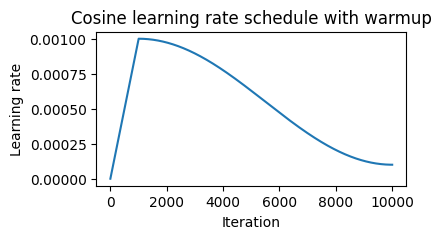

In [ ]:
# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# TODO TASK 2.1
#
# create a mapping from characters to integers (stoi) and from integers to characters (itos)
#
stoi = {ch: i for i, ch in enumerate(chars)}  # map characters to integers
itos = {i: ch for i, ch in enumerate(chars)}  # map integers to characters

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = encode(train_data)
val_ids = encode(val_data)
train_data = np.array(train_ids, dtype=np.uint16)
val_data = np.array(val_ids, dtype=np.uint16)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

CUDA = True
device = "cuda" if CUDA else "cpu"
# data
batch_size = 32
block_size = 256
# model
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2
# adamw optimizer
learning_rate = 1e-3 # max learning rate
max_iters = 10000 # total number of training iterations
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
warmup_iters = 1000 # how many steps to warm up for
lr_decay_iters = max_iters
min_lr = 1e-4
# logging
eval_interval = 100
eval_iters = 10
log_interval = 10
# generation
max_new_tokens = 100
temperature = 0.8
top_k = None

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    # TODO TASK 2.2
    #
    # Define the targets that would implement next-token prediction
    #
    y = torch.stack([torch.from_numpy((data[i+1:i+block_size+1]).astype(np.int64)) for i in ix])
    if device == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

lr_seq = [get_lr(i) for i in range(max_iters)]
plt.figure(figsize=(4, 2))
plt.plot(lr_seq)
plt.title('Cosine learning rate schedule with warmup')
plt.xlabel('Iteration')
plt.ylabel('Learning rate')
plt.show()




In [ ]:
# We define the model
model = GPT(n_layer, n_embd, n_head, block_size, vocab_size, dropout)
model.to(device)
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
iter_num = 0 # number of iterations in the lifetime of this process
while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    # evaluate the loss on train/val sets
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        start = " "
        start_ids = encode(start)
        x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
        # run generation
        model.eval()
        try:
            with torch.no_grad():
                y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        except Exception as e:
            pass # If you haven't implemented the generate code
        model.train()
        print('-' * 100)
        print("Example generated:")
        print('-' * 100)
        print(decode(y[0].tolist()))
        print('-' * 100)
    logits, loss = model(X, Y)
    X, Y = get_batch('train')
    # clip the gradient
    if grad_clip != 0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0:
        lossf = loss.item() # loss as float. note: this is a CPU-GPU sync point
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms")
    iter_num += 1
    # termination conditions
    if iter_num > max_iters:
        break

step 0: train loss 4.5108, val loss 4.5107
----------------------------------------------------------------------------------------------------
Example generated:
----------------------------------------------------------------------------------------------------
 OH'72	D=hw(L1990;u'a!*mCG/Jl"cZM'YFI*_OB.$:.D!SD:\tZH%;Fbp=,n*5lCcJWK!,Bz$a7=V~VP.0%L	BlKrZlwm%TtZL
----------------------------------------------------------------------------------------------------
iter 0: loss 4.5108, time 2037.08ms
iter 10: loss 4.5099, time 241.82ms
iter 20: loss 4.5070, time 223.83ms
iter 30: loss 4.5009, time 256.13ms
iter 40: loss 4.4870, time 237.34ms
iter 50: loss 4.4681, time 251.45ms
iter 60: loss 4.4530, time 242.81ms
iter 70: loss 4.4378, time 245.88ms
iter 80: loss 4.4178, time 249.57ms
iter 90: loss 4.3922, time 239.79ms
step 100: train loss 4.3550, val loss 4.3521
----------------------------------------------------------------------------------------------------
Example generated:
--------

In [ ]:
with open("wuggy.txt", 'r') as f:
    spelling_samples = [sample[:-1].split(',') for sample in f]
with open("blimp.txt", 'r') as f:
    grammar_test_samples = [sample[:-1].split(',') for sample in f]
print(spelling_samples[0])
print(grammar_test_samples[0])

['objectivity', 'osbrectifity']
["Harry hadn't attacked himself", "Harry hadn't attacked herself"]


In [ ]:
def get_sample_prob(X):
    #
    # TODO TASK 3
    #
    # Compute the probability of sequence X
    #
    logits, _ = model(X[:, :-1])
    log_probs = F.log_softmax(logits, dim=-1)

    targets = X[:, 1:]  # The target tokens are shifted by one position

    gathered_log_probs = torch.gather(log_probs, 2, targets.unsqueeze(1)).squeeze(2)
    # print(gathered_log_probs.shape)
    # Sum the log probabilities for the entire sequence
    sequence_log_prob = gathered_log_probs.sum()
    return torch.tensor(sequence_log_prob).cpu().detach()

spelling_scores = []
for sample in tqdm(spelling_samples):
    word, non_word = sample
    tokenized_word = torch.tensor(encode(word), dtype=torch.long).unsqueeze(0)  # Encode and batch
    prob_word = get_sample_prob(tokenized_word.to(device))
    tokenized_non_word = torch.tensor(encode(non_word), dtype=torch.long).unsqueeze(0)  # Encode and batch
    prob_non_word = get_sample_prob(tokenized_non_word.to(device))
    spelling_scores.append(1.0 * (prob_word > prob_non_word))  # Higher probability for the correct word
print("Spelling score: ", np.mean(spelling_scores))

grammar_scores = []
for sample in tqdm(grammar_test_samples):
    sentence, non_sentence = sample
    tokenized_sentence = torch.tensor(encode(sentence), dtype=torch.long).unsqueeze(0)  # Encode and batch
    prob_sentence = get_sample_prob(tokenized_sentence.to(device))
    tokenized_non_sentence = torch.tensor(encode(non_sentence), dtype=torch.long).unsqueeze(0)  # Encode and batch
    prob_non_sentence = get_sample_prob(tokenized_non_sentence.to(device))
    grammar_scores.append(1.0 * (prob_sentence > prob_non_sentence))  # Higher probability for the correct sentence
print("Grammar score: ", np.mean(grammar_scores))


  0%|          | 0/40000 [00:00<?, ?it/s]

<ipython-input-40-f81436d45e03>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sequence_log_prob).cpu().detach()


Spelling score:  0.511125


  0%|          | 0/500 [00:00<?, ?it/s]

Grammar score:  0.462


## Explanation
Top-k Sampling and Key-Value Caching in Transformer Models:

Top-k Sampling: This technique refines the model's text generation by restricting its predictions to the K most probable next words, effectively filtering out less likely options. This significantly improves the clarity, coherence, and overall quality of the generated text, especially during the early stages of training when the model's predictions are still unrefined. By reducing randomness in word selection, top-k sampling ensures that the output aligns more closely with logical and contextually appropriate language patterns.

Key-Value Caching: This optimization addresses the efficiency challenges of transformer models, particularly for processing long sequences. During inference, key-value caching stores the attention key and value pairs from previous steps, avoiding redundant computations when generating subsequent tokens. This not only accelerates the generation process but also reduces memory overhead, making it a crucial feature for real-time applications and tasks involving lengthy text inputs.

Together, top-k sampling and key-value caching play complementary roles: top-k sampling enhances the quality of the output, ensuring it is coherent and meaningful, while key-value caching boosts computational efficiency, enabling the model to handle complex and long-form tasks effectively. These techniques are instrumental in balancing performance and practicality in transformer-based models like GPT.

# Problem 3. Vision transformer

Transformers go well beyond text. They have been applied with tremendous success to many modalities (audio, images, video, graphs, etc). However, its application to images can be unintuitive, as we do not tend to think of them as the 1D sequences for which transformers were designed. In this exercise we will implement a vision transformer to illustrate how this works.

We use the classic MNIST dataset and will try to get a vision transformer to do classification of handwritten numbers.

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.61MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Let's take a look at one of the samples:

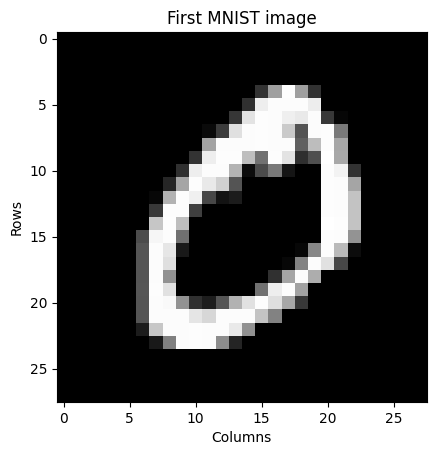

In [ ]:
first_image = np.array(mnist_trainset[1][0])
plt.imshow(first_image, cmap='gray')
plt.title('First MNIST image')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

The way we turn an image into a 1D sequence is pretty straightforward. We can simply flatten it in a row major form. That is, we will turn our 28x28 pixels image into a 784 long sequence, with the first row becoming the first 24 elements, the second row the next, and so on.

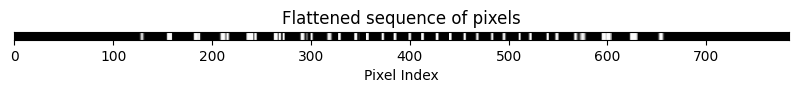

In [ ]:
flattened_image = first_image.reshape(-1)
plt.figure(figsize=(10, 0.1))
plt.imshow([flattened_image], cmap='gray', aspect='auto')
plt.title('Flattened sequence of pixels')
plt.xlabel('Pixel Index')
plt.yticks([])
plt.show()

This should work fine, but there is a technical issue. Remember that transformer's computational cost scales quadratically with the length of the sequence. Notice that our tiny 24x24 pixels image already results in a sequence of length 784. This is ok as long as you have a moderately large GPU and you use a not too large batch size, but in Colab, or in the smallest GPUs in our cluster we might already run into memory issues. Moreover, in most practical applications we will be dealing with much larger images. For a standard HD image of 1024 x 768 pixels we would have a sequence length of 786432! This is already almost 10 times more than what the state-of-the-art models like GPT-4 support.

In practice, instead of working on sequences of pixels, we use sequences of image patches. We will split our image into non-overlapping 4x4 patches:

Text(0.5, 1.0, 'Image with 4x4 Patches')

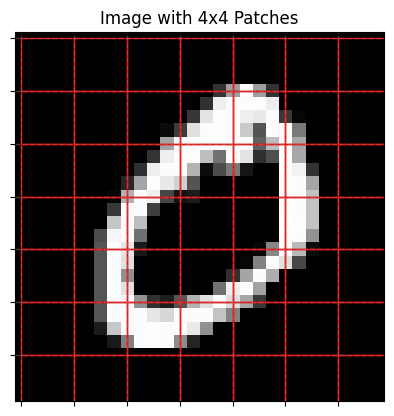

In [ ]:
image_size = first_image.shape[0]
patch_size = 4
fig, ax = plt.subplots()
ax.imshow(first_image, cmap='gray')
for i in range(0, image_size, patch_size):
    for j in range(0, image_size, patch_size):
        rect = Rectangle((j, i), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
ax.set_xticks(np.arange(0, image_size, patch_size))
ax.set_yticks(np.arange(0, image_size, patch_size))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True, which='both', linestyle='--', linewidth=1, color='gray', alpha=0.5)
plt.title(f'Image with {patch_size}x{patch_size} Patches')

When we flattened it, it becomes a sequence of 49 patches:

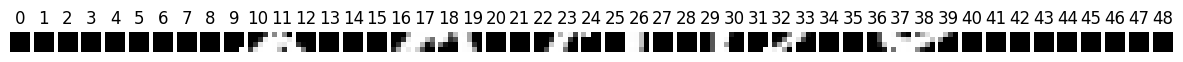

In [ ]:
patch_sequence = []
for i in range(0, image_size, patch_size):
    for j in range(0, image_size, patch_size):
        patch = first_image[i:i+patch_size, j:j+patch_size]
        patch_sequence.append(patch)
num_patches = (image_size // patch_size) ** 2
fig, axs = plt.subplots(1, num_patches, figsize=(15, 2))
for i, patch in enumerate(patch_sequence):
    axs[i].imshow(patch, cmap='gray')
    axs[i].set_title(i)
    axs[i].axis('off')

plt.show()

_Note: in most practical applications we will be dealing with much larger images, so we will need larger patches in order to sufficiently shorten the sequence length._


Finally we transform each patch, a 4x4 matrix, into a vector of 16 elements, which is the input our transformer expects. We simply flatten each patch:

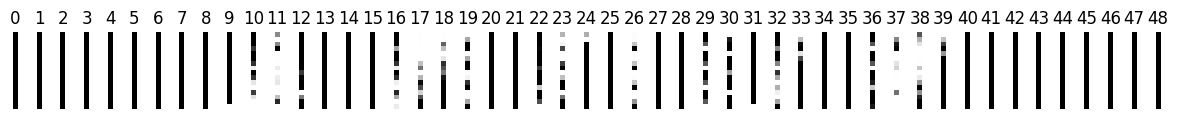

In [ ]:
fig, axs = plt.subplots(1, num_patches, figsize=(15, 1))
for i, patch in enumerate(patch_sequence):
    axs[i].imshow(patch.reshape(-1, 1), cmap='gray')
    axs[i].set_title(i)
    axs[i].axis('off')
plt.show()

We have our inputs ready. Now onto the model. This is the architecture our digit classifier will use:
    
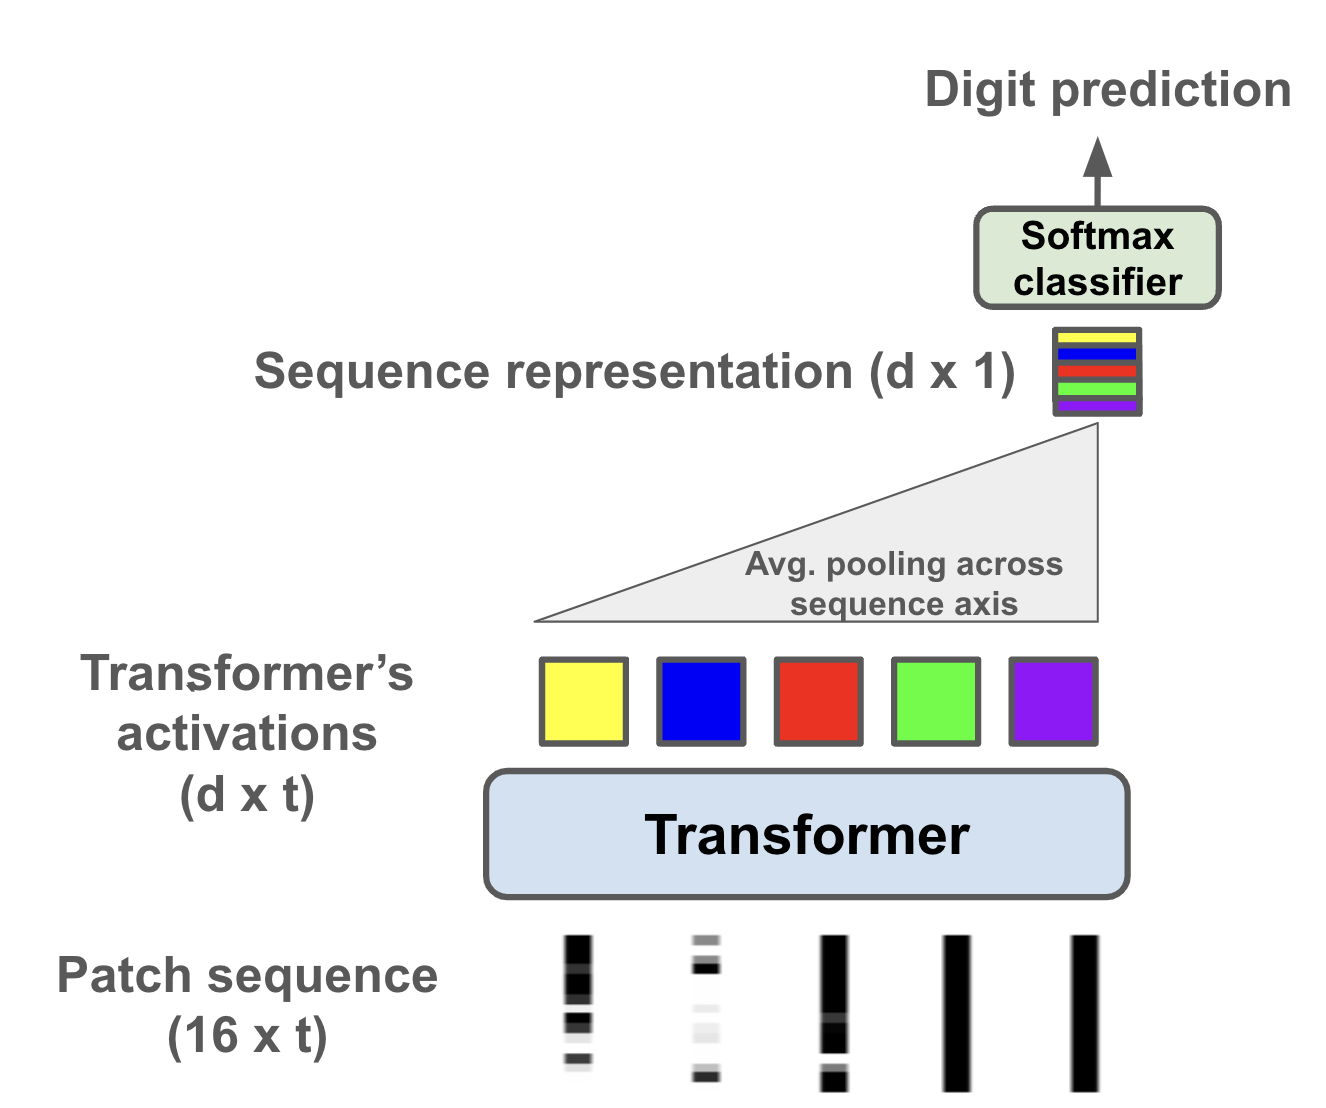

**Tasks**:
1. **(3 pt)** Implement the architecture of the classifier in the class `VisionTransformer` and train it on the MNIST dataset. Note that you can reuse most of the elements that you already implemented for `GPT`. You just need to avoid auto-regressive masking and figure out how to input the patches instead of discrete tokens.
2. **(2 pt)** Implement a simple convolutional network classifier and compare its performnace with the vision transformer.
3. **(4 pt máx)** Implement any of the two methods from the paper [Vision Transformer for Small-Size Datasets](https://arxiv.org/pdf/2112.13492v1.pdf) to try to improve the performance of our model. You can find a Keras tutorial implementing them [here](https://keras.io/examples/vision/vit_small_ds/#implement-locality-self-attention). Each method is worth **2 pt**. **NOTE: the Keras tutorial is meant as guidance, you would need to port it to our framework, PyTorch.**

Let's start defining some parameters. As before, it works with these defaults, but you can play with them

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

device = "cuda" if CUDA else "cpu"
# data
batch_size = 32
patch_size = 4
img_w, img_h = np.array(mnist_trainset[1][0]).shape
block_size = img_w // patch_size * img_h // patch_size
# model
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2
input_size = patch_size * patch_size
n_classes = 10 # 10-digit classification
# adamw optimizer
learning_rate = 5e-4 # max learning rate
max_iters = 10000 # total number of training iterations
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
warmup_iters = 1000 # how many steps to warm up for
lr_decay_iters = max_iters
min_lr = 5e-5
# logging
eval_interval = 1000
log_interval = 100

Now we preprocess our dataset to transform every image into patch sequences of shape `(49, patch_size, patch_size)`

In [ ]:
# Transformation to extract patches and flatten them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)),
    transforms.Lambda(lambda x: x.contiguous().view(-1, patch_size, patch_size)),
])

# Apply the transform to the loaded datasets
mnist_trainset.transform = transform
mnist_testset.transform = transform

Here you have to define the model:

In [ ]:

class VisionTransformer(nn.Module):
    def __init__(self, input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout):
        super().__init__()

        """# TODO TASK 1 #"""
        self.block_size = block_size

        self.block_size = block_size

        # Define the transformer components
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Linear(input_size, n_embd),  # Linear layer for patch embedding
            wpe=nn.Embedding(block_size, n_embd),  # Positional embedding layer
            drop=nn.Dropout(dropout), # Dropout layer
            h=nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)]),  # Transformer blocks
            ln_f=nn.LayerNorm(n_embd),  # Layer normalization
        ))

        # Classifier head
        self.classifier = nn.Linear(n_embd, n_classes)
        # init weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        # Initialize weights
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        device = x.device
        b, t = x.size(0), x.size(1)
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        """# TODO TASK 1 #"""
        # Compute patch embeddings and add positional encodings
        x = self.transformer.wte(x)  # Patch embeddings
        pos = torch.arange(t, device=device)  # Position indices
        x = x + self.transformer.wpe(pos)[None, :, :]  # Add positional embeddings
        x = self.transformer.drop(x)  # Apply dropout

        # Pass through each transformer block
        for block in self.transformer.h:
            x = block(x)

        # Apply final layer normalization
        x = self.transformer.ln_f(x)

        # Classifier head
        # Mean pooling is used before the classification layer
        logits = self.classifier(x.mean(dim=1))  # Using mean pooling here

        # Compute loss if targets are provided
        loss = F.cross_entropy(logits, targets) if targets is not None else None
        return logits, loss


## Explanation
The VisionTransformer class implements a vision-based transformer model, designed for image classification tasks. It divides an input image into patches, computes embeddings for each patch using a linear layer (wte), and incorporates positional information via positional embeddings (wpe). These embeddings are processed through a series of transformer blocks (h), which include multi-head self-attention and feed-forward layers, enabling the model to capture global relationships among image patches. A dropout layer is applied for regularization, and layer normalization (ln_f) ensures stable training. After passing through the transformer blocks, the embeddings are averaged (mean pooling) to produce a single representation for the input, which is passed to a classifier head for final predictions over the given number of classes. The model also supports loss computation when training labels are provided, using cross-entropy as the loss function. The weight initialization ensures stable model performance from the start. This architecture leverages the transformer’s ability to model long-range dependencies, making it highly effective for image-based tasks.

In [ ]:
# Create data loaders
train_loader = DataLoader(dataset=mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=mnist_testset, batch_size=batch_size, shuffle=False)

# Model
model = VisionTransformer(input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout)
model.to(device)
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

iter_counter = 0
vit_losses = []  # List to store test losses for Vision Transformer
vit_accuracy = [] # List to store accuracy metrics

while iter_counter < max_iters:
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Flatten the patch
        patch_sequence = data.view(-1, block_size, patch_size * patch_size).to(device)
        target = target.to(device)
        # Forward pass
        logits, loss = model(patch_sequence, target)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculate accuracy
        _, predicted = torch.max(logits, -1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        total_loss += loss.item()
        iter_counter += 1
        # Log loss and accuracy
        if iter_counter % log_interval == 0:
            avg_loss = total_loss / log_interval
            accuracy = correct / total
            print(f'Iter [{iter_counter}/{max_iters}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
            total_loss = 0.0
            correct = 0
            total = 0
        # Evaluate test loss
        if iter_counter % eval_interval == 0 or iter_counter == max_iters:
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for test_data, test_target in test_loader:
                    test_patch_sequence = test_data.view(-1, block_size, patch_size * patch_size).to(device)
                    test_target = test_target.to(device)
                    test_outputs, loss = model(test_patch_sequence, test_target)
                    test_loss += loss.item()
                    vit_losses.append(loss.item())
                    _, test_predicted = torch.max(test_outputs, -1)
                    test_total += test_target.size(0)
                    test_correct += (test_predicted == test_target).sum().item()

            avg_test_loss = test_loss / len(test_loader)
            test_accuracy = test_correct / test_total
            vit_accuracy.append(test_accuracy)

            print(f'Iter [{iter_counter}/{max_iters}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
            model.train()
        if iter_counter == max_iters:
            break

Iter [100/10000], Batch [100/1875], Loss: 2.1972, Accuracy: 22.09%
Iter [200/10000], Batch [200/1875], Loss: 1.8524, Accuracy: 31.56%
Iter [300/10000], Batch [300/1875], Loss: 1.6173, Accuracy: 39.94%
Iter [400/10000], Batch [400/1875], Loss: 1.5927, Accuracy: 37.91%
Iter [500/10000], Batch [500/1875], Loss: 1.4980, Accuracy: 42.50%
Iter [600/10000], Batch [600/1875], Loss: 1.4597, Accuracy: 44.00%
Iter [700/10000], Batch [700/1875], Loss: 1.4199, Accuracy: 45.16%
Iter [800/10000], Batch [800/1875], Loss: 1.3484, Accuracy: 48.91%
Iter [900/10000], Batch [900/1875], Loss: 1.2637, Accuracy: 53.31%
Iter [1000/10000], Batch [1000/1875], Loss: 1.1928, Accuracy: 56.97%
Iter [1000/10000], Batch [1000/1875], Test Loss: 1.0672, Test Accuracy: 60.97%
Iter [1100/10000], Batch [1100/1875], Loss: 1.1132, Accuracy: 59.44%
Iter [1200/10000], Batch [1200/1875], Loss: 1.0185, Accuracy: 63.12%
Iter [1300/10000], Batch [1300/1875], Loss: 0.9374, Accuracy: 65.62%
Iter [1400/10000], Batch [1400/1875], Loss

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(dataset=mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=mnist_testset, batch_size=batch_size, shuffle=False)


In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        """
        Initializes the SimpleCNN model.

        Args:
            n_classes (int): The number of classes for the classification task.
        """
        super().__init__()
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # 32 filters, 3x3 kernel, stride 1, padding 1
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer with 2x2 kernel, stride 2

            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64 filters, 3x3 kernel, stride 1, padding 1
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2) # Max pooling layer with 2x2 kernel, stride 2
        )

        # Fully connected (dense) layers
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 1024),  # Linear layer with 1024 output features
            nn.ReLU(),  # Activation function
            nn.Dropout(0.5),  # Dropout layer with 50% probability
            nn.Linear(1024, n_classes)  # Final linear layer with output size equal to the number of classes
        )

    def forward(self, x):
        """
        Forward pass of the SimpleCNN.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying log softmax.
        """
        x = self.conv_layers(x) # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the output for the dense layers
        x = self.fc_layers(x) # Apply fully connected layers
        return F.log_softmax(x, dim=1)  # Apply log softmax to the output

In [ ]:
def train(model, device, train_loader, optimizer, max_iters, log_interval):
    model.train() # Set the model to training mode
    total_loss = 0  # Total loss for all batches
    correct = 0 # Total number of correct predictions
    total = 0 # Total number of processed samples
    iter_counter = 0  # Count the number of iterations

    while iter_counter < max_iters:
        for batch_idx, (data, target) in enumerate(train_loader):
            if iter_counter >= max_iters:
                break

            # Move data to the specified device (e.g., GPU)
            data, target = data.to(device), target.to(device)
            # Reset gradients
            optimizer.zero_grad()
            # Forward pass: compute the model output
            output = model(data)
            # Compute the loss
            loss = F.nll_loss(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Update model parameters
            optimizer.step()

            # Update training statistics
            total_loss += loss.item() * data.size(0)  # Multiply by batch size for accurate average
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)
            iter_counter += 1

            # Log training statistics
            if iter_counter % log_interval == 0:
                avg_loss = total_loss / total  # Average loss across all processed batches
                accuracy = 100. * correct / total # Calculate accuracy
                print(f'Iteration: {iter_counter}/{max_iters}, Loss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%')
                total_loss = 0
                correct = 0
                total = 0


def test(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0 # Total loss on the test set
    correct = 0 # Total number of correct predictions
    with torch.no_grad(): # Disable gradient calculation
        for data, target in test_loader:
            # Move data to the specified device (e.g., GPU)
            data, target = data.to(device), target.to(device)
            # Compute model output
            output = model(data)
            # Sum up the loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Sum up batch loss
            # Calculate the number of correct predictions
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate average loss and accuracy
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

In [ ]:
total_samples = len(mnist_trainset)

num_batches_per_epoch = total_samples / batch_size
num_epochs = int(round(max_iters / num_batches_per_epoch))

# Instantiate models
cnn_model = SimpleCNN(n_classes).to(device)

# Optimizer Adam for CNN
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

# Define a transformation pipeline for the MNIST dataset
transform_cnn = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize images with MNIST mean and standard deviation
])

# Create MNIST dataset instances for training and testing with the defined transformation
mnist_trainset_cnn = datasets.MNIST(root='./data', train=True, download=True, transform=transform_cnn)
mnist_testset_cnn = datasets.MNIST(root='./data', train=False, download=True, transform=transform_cnn)

# Create DataLoader instances for training and testing
train_loader_cnn = DataLoader(mnist_trainset_cnn, batch_size=batch_size, shuffle=True)
test_loader_cnn = DataLoader(mnist_testset_cnn, batch_size=batch_size, shuffle=False)

# Train the CNN model
train(cnn_model, device, train_loader_cnn, optimizer_cnn, max_iters, log_interval=100)
# Test the CNN model
test(cnn_model, device, test_loader_cnn)

Iteration: 100/10000, Loss: 0.742488, Accuracy: 76.34%
Iteration: 200/10000, Loss: 0.213893, Accuracy: 93.03%
Iteration: 300/10000, Loss: 0.165215, Accuracy: 95.03%
Iteration: 400/10000, Loss: 0.136743, Accuracy: 95.50%
Iteration: 500/10000, Loss: 0.122911, Accuracy: 96.78%
Iteration: 600/10000, Loss: 0.118713, Accuracy: 96.31%
Iteration: 700/10000, Loss: 0.105377, Accuracy: 96.91%
Iteration: 800/10000, Loss: 0.100269, Accuracy: 97.09%
Iteration: 900/10000, Loss: 0.083475, Accuracy: 97.47%
Iteration: 1000/10000, Loss: 0.086999, Accuracy: 97.56%
Iteration: 1100/10000, Loss: 0.087124, Accuracy: 97.22%
Iteration: 1200/10000, Loss: 0.074409, Accuracy: 97.56%
Iteration: 1300/10000, Loss: 0.072797, Accuracy: 97.59%
Iteration: 1400/10000, Loss: 0.068672, Accuracy: 97.62%
Iteration: 1500/10000, Loss: 0.076409, Accuracy: 97.72%
Iteration: 1600/10000, Loss: 0.091098, Accuracy: 97.31%
Iteration: 1700/10000, Loss: 0.067816, Accuracy: 97.75%
Iteration: 1800/10000, Loss: 0.067146, Accuracy: 98.06%
I

In [ ]:
def evaluate_model(model, device, test_loader):
    """
    Evaluates the given model on the test dataset.

    This function supports different types of models, including Vision Transformer and
    traditional CNNs. It handles data preparation differently for Vision Transformers
    and computes the average loss and accuracy over the entire test dataset.

    Args:
        model (torch.nn.Module): The model to be evaluated. Can be a Vision Transformer, CNN, or any other PyTorch model.
        device (torch.device): The device on which to perform the evaluation (e.g., 'cuda', 'cpu').
        test_loader (torch.utils.data.DataLoader): The DataLoader providing the test dataset.

    Returns:
        list: A list of losses for each batch in the test dataset.
        float: The average loss over the entire test dataset.
        float: The accuracy percentage over the entire test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    test_losses = []  # List to store the loss of each batch
    correct = 0 # Counter for the number of correct predictions
    with torch.no_grad(): # Disable gradient computation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Handle Vision Transformer output
            if isinstance(model, VisionTransformer):
                # Flatten patches for Vision Transformer
                data = data.view(-1, block_size, patch_size * patch_size)  # Flatten patches for Vision Transformer
                # Forward pass through the model
                logits, _ = model(data, target)
                # Convert logits to probabilities
                outputs = F.log_softmax(logits, dim=1)
            else:
                # Handle CNN and other model outputs
                outputs = model(data)
                 # If the output is a tuple (logits, loss), extract the logits
                if isinstance(outputs, tuple):
                    outputs = outputs[0]  # Assuming the first element is the logits for models that return a tuple

            # Compute the loss
            loss = F.nll_loss(outputs, target, reduction='sum').item()
            test_losses.append(loss)  # Append loss to the list

            # Compute accuracy
            pred = outputs.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate the average loss and accuracy
    average_loss = sum(test_losses) / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_losses, average_loss, accuracy


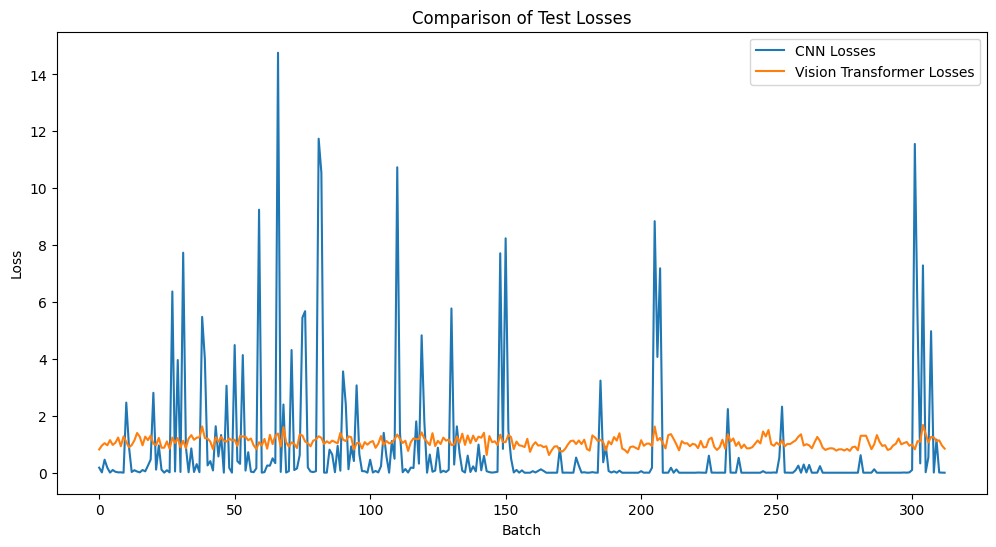

In [ ]:
# Evaluate the CNN
test_losses_cnn, avg_loss_cnn, accuracy_cnn = evaluate_model(cnn_model, device, test_loader_cnn)

plt.figure(figsize=(12, 6))
plt.plot(test_losses_cnn, label='CNN Losses')
plt.plot(vit_losses[:len(test_losses_cnn)], label='Vision Transformer Losses')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Comparison of Test Losses')
plt.legend()
plt.show()

## Explanation

This plot compares the test losses of two models: a Convolutional Neural Network (CNN) and a Vision Transformer (ViT). The blue line represents the CNN losses, which exhibit significant variability with frequent spikes, indicating instability during testing. This variability could stem from the CNN's reliance on local spatial features, which may lead to inconsistencies when handling diverse or complex test samples. In contrast, the orange line represents the Vision Transformer losses, which are much smoother and more stable across batches. This stability suggests that the Vision Transformer is better at capturing global dependencies and patterns in the data, leading to more consistent predictions.

The plot highlights the robustness of the Vision Transformer in handling test data compared to the CNN, which appears more sensitive to sample variability.

## Implimenatation of SPT and LSA from the paper

The given paper introduces two methods to enhance the locality inductive bias of Vision Transformers (ViTs), enabling them to perform better on small-sized datasets when trained from scratch. The first method, Shifted Patch Tokenization (SPT), improves the tokenization process by incorporating spatial relationships between neighboring pixels. Inspired by the Temporal Shift Module (TSM), SPT spatially shifts parts of the input image and tokenizes the original and shifted images together. This approach increases the receptive field of the ViT, embedding more spatial information into each visual token and thus enhancing the model's ability to capture local features.

The second method, Locality Self-Attention (LSA), modifies the self-attention mechanism to focus more on local information. By excluding self-tokens and introducing a learnable temperature to the softmax function, LSA reduces the smoothing of attention score distributions. This encourages each token to prioritize nearby tokens with strong relationships, effectively guiding the model to attend locally.

Both SPT and LSA can be seamlessly integrated into existing ViTs as add-on modules without altering their architecture. These methods lead to significant performance improvements across various datasets. For instance, experiments show an increase in classification accuracy by up to 29.6% on Tiny-ImageNet and up to 10.6% on larger datasets like ImageNet. Qualitative results also demonstrate that these techniques enable ViTs to capture object shapes more effectively, enhancing their understanding of spatial relationships. Overall, SPT and LSA significantly improve ViT performance with minimal computational overhead.

Shifted Patch Tokenization (SPT)

Iter [50/1000] Train Loss: 1.2867, Train Accuracy: 55.69%
Iter [100/1000] Train Loss: 0.5900, Train Accuracy: 80.38%
Iter [100/1000] Test Loss: 0.5393, Test Accuracy: 82.39%
Iter [150/1000] Train Loss: 0.4781, Train Accuracy: 85.62%
Iter [200/1000] Train Loss: 0.4421, Train Accuracy: 86.56%
Iter [200/1000] Test Loss: 0.4318, Test Accuracy: 86.05%
Iter [250/1000] Train Loss: 0.4214, Train Accuracy: 87.25%
Iter [300/1000] Train Loss: 0.3923, Train Accuracy: 87.88%
Iter [300/1000] Test Loss: 0.3896, Test Accuracy: 87.51%
Iter [350/1000] Train Loss: 0.4017, Train Accuracy: 88.25%
Iter [400/1000] Train Loss: 0.4025, Train Accuracy: 87.25%
Iter [400/1000] Test Loss: 0.3510, Test Accuracy: 89.07%
Iter [450/1000] Train Loss: 0.3944, Train Accuracy: 88.62%
Iter [500/1000] Train Loss: 0.3336, Train Accuracy: 90.06%
Iter [500/1000] Test Loss: 0.2947, Test Accuracy: 91.06%
Iter [550/1000] Train Loss: 0.2656, Train Accuracy: 92.19%
Iter [600/1000] Train Loss: 0.2998, Train Accuracy: 90.75%
Iter [60

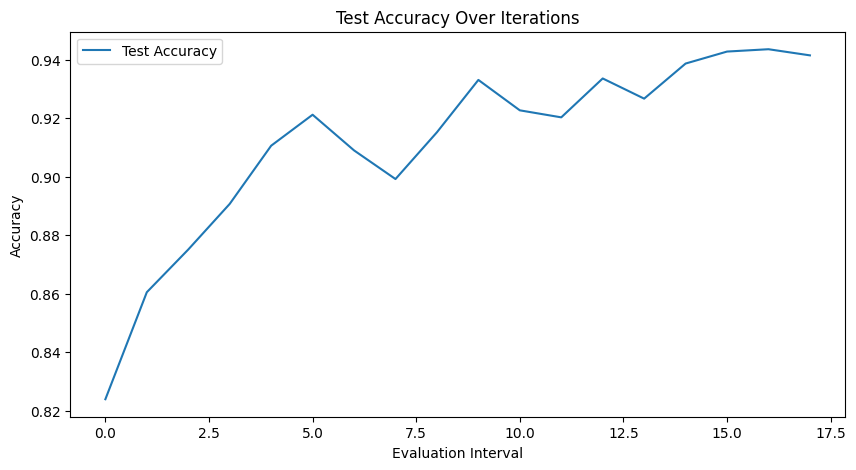

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# Define Shifted Patch Dataset
class ShiftedPatchDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        image = np.array(image)

        up = np.roll(image, -1, axis=0)
        down = np.roll(image, 1, axis=0)
        left = np.roll(image, -1, axis=1)
        right = np.roll(image, 1, axis=1)

        stacked_images = np.stack([image, up, down, left, right], axis=0)
        stacked_images = stacked_images.reshape(5, -1)  # Each patch is flattened
        return torch.tensor(stacked_images, dtype=torch.float32), label

# Define the Vision Transformer Block
class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = nn.MultiheadAttention(n_embd, n_head, dropout=dropout, batch_first=True)
        self.ln_2 = nn.LayerNorm(n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.ln_1(x), self.ln_1(x), self.ln_1(x))[0]
        x = x + self.mlp(self.ln_2(x))
        return x

# Define the Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self, input_size, n_classes, n_layer, n_embd, n_head, dropout):
        super().__init__()
        self.embedding = nn.Linear(input_size, n_embd)
        self.positional_encoding = nn.Embedding(5, n_embd)  # Hardcoded for 5 patches
        self.transformer_blocks = nn.ModuleList([
            Block(n_embd, n_head, dropout) for _ in range(n_layer)
        ])
        self.ln_f = nn.LayerNorm(n_embd)
        self.classifier = nn.Linear(n_embd, n_classes)

    def forward(self, x, targets=None):
        b, t, _ = x.size()
        positions = torch.arange(t, device=x.device).unsqueeze(0).expand(b, t)

        x = self.embedding(x) + self.positional_encoding(positions)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.classifier(x.mean(dim=1))

        loss = F.cross_entropy(logits, targets) if targets is not None else None
        return logits, loss

# Dataset Preparation
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

shifted_trainset = ShiftedPatchDataset(mnist_trainset)
shifted_testset = ShiftedPatchDataset(mnist_testset)

batch_size = 32
train_loader = DataLoader(shifted_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(shifted_testset, batch_size=batch_size, shuffle=False)

# Model Configuration
patch_size = 28  # Adjusted to match MNIST's 28x28 size
input_size = patch_size * patch_size
n_classes = 10
n_layer = 6
n_embd = 384
n_head = 6
dropout = 0.2
learning_rate = 1e-4

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(input_size, n_classes, n_layer, n_embd, n_head, dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training and Evaluation
max_iters = 1000
eval_interval = 100
log_interval = 50

iter_counter = 0
train_losses, test_losses, test_accuracies = [], [], []

while iter_counter < max_iters:
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        logits, loss = model(data, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = logits.argmax(dim=-1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
        iter_counter += 1

        if iter_counter % log_interval == 0:
            avg_loss = total_loss / log_interval
            accuracy = correct / total
            print(f"Iter [{iter_counter}/{max_iters}] Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy * 100:.2f}%")
            train_losses.append(avg_loss)
            total_loss, correct, total = 0.0, 0, 0

        if iter_counter % eval_interval == 0 or iter_counter == max_iters:
            model.eval()
            test_loss, test_correct, test_total = 0.0, 0, 0

            with torch.no_grad():
                for test_data, test_target in test_loader:
                    test_data = test_data.to(device)
                    test_target = test_target.to(device)

                    test_logits, loss = model(test_data, test_target)
                    test_loss += loss.item()
                    test_predicted = test_logits.argmax(dim=-1)
                    test_correct += (test_predicted == test_target).sum().item()
                    test_total += test_target.size(0)

            avg_test_loss = test_loss / len(test_loader)
            test_accuracy = test_correct / test_total
            print(f"Iter [{iter_counter}/{max_iters}] Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
            test_losses.append(avg_test_loss)
            test_accuracies.append(test_accuracy)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy Over Iterations')
plt.xlabel('Evaluation Interval')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Iter [50/1000] Train Loss: 1.3826, Train Accuracy: 54.06%
Iter [100/1000] Train Loss: 0.6916, Train Accuracy: 78.50%
Iter [100/1000] Test Loss: 0.5000, Test Accuracy: 85.55%
Iter [150/1000] Train Loss: 0.4854, Train Accuracy: 85.75%
Iter [200/1000] Train Loss: 0.4526, Train Accuracy: 85.44%
Iter [200/1000] Test Loss: 0.4035, Test Accuracy: 87.67%
Iter [250/1000] Train Loss: 0.4406, Train Accuracy: 86.81%
Iter [300/1000] Train Loss: 0.3973, Train Accuracy: 87.75%
Iter [300/1000] Test Loss: 0.3817, Test Accuracy: 88.85%
Iter [350/1000] Train Loss: 0.4245, Train Accuracy: 87.06%
Iter [400/1000] Train Loss: 0.3368, Train Accuracy: 89.94%
Iter [400/1000] Test Loss: 0.3623, Test Accuracy: 88.89%
Iter [450/1000] Train Loss: 0.3554, Train Accuracy: 89.00%
Iter [500/1000] Train Loss: 0.3619, Train Accuracy: 89.12%
Iter [500/1000] Test Loss: 0.2909, Test Accuracy: 91.47%
Iter [550/1000] Train Loss: 0.3311, Train Accuracy: 90.44%
Iter [600/1000] Train Loss: 0.3251, Train Accuracy: 90.06%
Iter [60

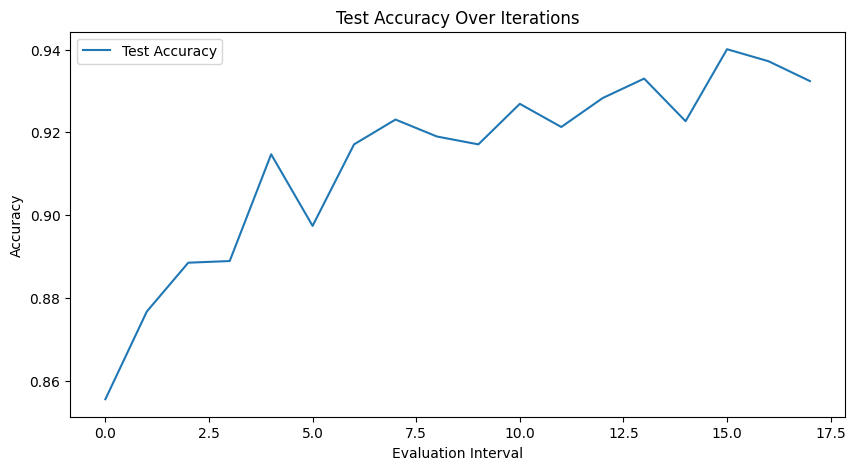

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# Define Shifted Patch Dataset
class ShiftedPatchDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        image = np.array(image)

        up = np.roll(image, -1, axis=0)
        down = np.roll(image, 1, axis=0)
        left = np.roll(image, -1, axis=1)
        right = np.roll(image, 1, axis=1)

        stacked_images = np.stack([image, up, down, left, right], axis=0)
        stacked_images = stacked_images.reshape(5, -1)  # Each patch is flattened
        return torch.tensor(stacked_images, dtype=torch.float32), label

# Define Locality Self-Attention (LSA)
class LocalitySelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.scale = nn.Parameter(torch.sqrt(torch.tensor(embed_dim // num_heads, dtype=torch.float32)))
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        b, t, d = x.size()
        qkv = self.qkv(x).reshape(b, t, 3, self.num_heads, d // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) / self.scale
        attn = attn.masked_fill(torch.eye(t, device=x.device).bool(), float('-inf'))  # Mask diagonal
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        out = (attn @ v).transpose(1, 2).reshape(b, t, d)
        return self.proj(out)

# Define the Vision Transformer Block with LSA
class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = LocalitySelfAttention(n_embd, n_head, dropout=dropout)
        self.ln_2 = nn.LayerNorm(n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

# Define the Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self, input_size, n_classes, n_layer, n_embd, n_head, dropout):
        super().__init__()
        self.embedding = nn.Linear(input_size, n_embd)
        self.positional_encoding = nn.Embedding(5, n_embd)  # Hardcoded for 5 patches
        self.transformer_blocks = nn.ModuleList([
            Block(n_embd, n_head, dropout) for _ in range(n_layer)
        ])
        self.ln_f = nn.LayerNorm(n_embd)
        self.classifier = nn.Linear(n_embd, n_classes)

    def forward(self, x, targets=None):
        b, t, _ = x.size()
        positions = torch.arange(t, device=x.device).unsqueeze(0).expand(b, t)

        x = self.embedding(x) + self.positional_encoding(positions)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.classifier(x.mean(dim=1))

        loss = F.cross_entropy(logits, targets) if targets is not None else None
        return logits, loss

# Dataset Preparation
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

shifted_trainset = ShiftedPatchDataset(mnist_trainset)
shifted_testset = ShiftedPatchDataset(mnist_testset)

batch_size = 32
train_loader = DataLoader(shifted_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(shifted_testset, batch_size=batch_size, shuffle=False)

# Model Configuration
patch_size = 28  # Adjusted to match MNIST's 28x28 size
input_size = patch_size * patch_size
n_classes = 10
n_layer = 6
n_embd = 384
n_head = 6
dropout = 0.2
learning_rate = 1e-4

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(input_size, n_classes, n_layer, n_embd, n_head, dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training and Evaluation
max_iters = 1000
eval_interval = 100
log_interval = 50

iter_counter = 0
train_losses, test_losses, test_accuracies = [], [], []

while iter_counter < max_iters:
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        logits, loss = model(data, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = logits.argmax(dim=-1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
        iter_counter += 1

        if iter_counter % log_interval == 0:
            avg_loss = total_loss / log_interval
            accuracy = correct / total
            print(f"Iter [{iter_counter}/{max_iters}] Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy * 100:.2f}%")
            train_losses.append(avg_loss)
            total_loss, correct, total = 0.0, 0, 0

        if iter_counter % eval_interval == 0 or iter_counter == max_iters:
            model.eval()
            test_loss, test_correct, test_total = 0.0, 0, 0

            with torch.no_grad():
                for test_data, test_target in test_loader:
                    test_data = test_data.to(device)
                    test_target = test_target.to(device)

                    test_logits, loss = model(test_data, test_target)
                    test_loss += loss.item()
                    test_predicted = test_logits.argmax(dim=-1)
                    test_correct += (test_predicted == test_target).sum().item()
                    test_total += test_target.size(0)

            avg_test_loss = test_loss / len(test_loader)
            test_accuracy = test_correct / test_total
            print(f"Iter [{iter_counter}/{max_iters}] Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
            test_losses.append(avg_test_loss)
            test_accuracies.append(test_accuracy)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy Over Iterations')
plt.xlabel('Evaluation Interval')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Explanation

The two plots illustrate the progression of test accuracy over training iterations for a Vision Transformer for both SPT and LSA. In both cases, the accuracy begins around 85-86% and steadily improves, eventually reaching approximately 94%. This upward trend highlights the model's ability to learn and adapt effectively to the task. The Shifted Patch Tokenization (SPT) exhibits a smoother improvement, while the Locally Self Attenation (LSA) model plot shows slightly more variability in intermediate evaluations, possibly due to differences in training configurations, random initialization, or hyperparameter tuning.